In [1]:
import numpy as np
import emcee

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm, Normalize
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import ImageGrid

from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
import corner

from astropy import units as u
from astropy import constants
from astropy.units import Quantity

import scipy 
from scipy import signal
from scipy.fft import fft, fftshift

import sys

import cmcrameri.cm as cmc
import corner
from tqdm import tqdm

import hera_sim
from pyuvdata import UVData
from uvtools.dspec import gen_window
from uvtools.plot import waterfall
from uvtools.utils import FFT, fourier_freqs


from hydra_pspec.sys_solver import sys_modes
from hydra_pspec.utils import form_pseudo_stokes_vis

from plotting_functions import plot_waterfalls,plot_waterfalls_from_dlfr
from functions import covariance_from_pspec,fourier_operator, data_dly_fr

basis_vector_type was not defined, defaulting to azimuth and zenith_angle.


# Setup

## Functions

In [2]:
# Check power spectrum
def calc_ps(s):
    # NOTE: This uses inverse FFT instead of FFT to get the right normalisation
    axes = (1,)
    sk = np.fft.ifftshift(s, axes=axes)
    sk = np.fft.fftn(sk, axes=axes)
    sk = np.fft.fftshift(sk, axes=axes)
    Nobs, Nfreqs = sk.shape
    return np.mean(sk * sk.conj(), axis=0).real / Nfreqs # CHECK: This takes an average

## Setting constants

In [3]:
Ntimes = 80 #60 #203
Nfreqs = 60
Nfgmodes=10

freqs = np.linspace(100., 120., 120) ##120) 
freqs = freqs[:Nfreqs]

lsts = np.linspace(0., 1., Ntimes)

df = (freqs[1] - freqs[0]) * u.MHz
delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to("1/ns")))

sys_amps_true = np.array([4. + 1j, 4.1 + 1j, 5. + 1j, 4. + 1j])

Niter = 10000
conf_interval=95
Nburn = 10
dl_inds=[[3,4,5,6],[10,11,12,13],[3,3,3,3]]

# Generate noise
fourier_op = fourier_operator(freqs.size, unitary=True)

noise_ps_val = 0.0004 #0.000004 #0.000004 # 0.0004
noise_ps_true = noise_ps_val * np.ones(Nfreqs)
N_true = covariance_from_pspec(noise_ps_true, fourier_op)
Ninv = np.diag(1./np.diag(N_true)) # get diagonal, invert, pack back into diagonal
n = np.sqrt(N_true) @ (np.random.randn(freqs.size, Ntimes) 
                    + 1.j*np.random.randn(freqs.size, Ntimes)) / np.sqrt(2.)
# Note factor of sqrt(2) above
noise_ps_check = calc_ps(n.T)


#Systematics Test case ---- Case III
nm_list = [(3,20),(4,20),(5,20),(6,20)]
sys_modes_operator = sys_modes(freqs_Hz=freqs*1e6, 
                                    times_sec=lsts * 24./(2.*np.pi) * 3600., 
                                    modes=nm_list)
sys_amps_true = np.array([4. + 1j, 4.1 + 1j, 5. + 1j, 4. + 1j])

3 20
4 20
5 20
6 20


## Plot Specs

In [4]:
'''Plot specs'''
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24})

'''Colour maps'''
paper_map=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:031D44-25:8DA9C4-50:EEF4ED-75:BC7C95-100:89043D
    (0.000, (0.012, 0.114, 0.267)),
    (0.250, (0.553, 0.663, 0.769)),
    (0.500, (0.933, 0.957, 0.929)),
    (0.750, (0.737, 0.486, 0.584)),
    (1.000, (0.537, 0.016, 0.239))))

paper_map_pink = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#EEF4ED-BC7C95-89043D
    (0.000, (0.933, 0.957, 0.929)),
    (0.500, (0.737, 0.486, 0.584)),
    (1.000, (0.537, 0.016, 0.239))))

paper_map_blue = LinearSegmentedColormap.from_list('my gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#EEF4ED-8DA9C4-031D44
    (0.000, (0.933, 0.957, 0.929)),
    (0.500, (0.553, 0.663, 0.769)),
    (1.000, (0.012, 0.114, 0.267))))


colors=['#1d3557','#ca6702',"#81babc",'#e63946','#ffc8dd']


In [5]:
dynamic_range=5

freqs_mhz = freqs * u.MHz
xticklocs=[1,10,20,30,40,50,59]
yticklocs=[0,10,20,30,40,50,60,70]

xstep_freqs = (freqs[-1]-freqs[0])/freqs.size

xticks_freqs= freqs_mhz[xticklocs]

xticklabels_freqs = [str(int(round(val,2))) for val in xticks_freqs.value]


formatter_freqs = ticker.ScalarFormatter(useMathText=True)
formatter_freqs.set_powerlimits((6, 6))  # Force sci notation for values >= 1e6

lsts_round=np.array([round(l,2) for l in lsts])
times = Quantity(np.unique(lsts_round * 12 / np.pi), unit='h')
fringe_rates = fourier_freqs(lsts * u.day.to('s')) * 1e3 # mHz

xstep_dl = (delays[-1]-delays[0])/delays.size
ystep_fr = (fringe_rates[-1]-fringe_rates[0])/Ntimes

xticks_dl= delays[xticklocs]
yticks_fr=fringe_rates[yticklocs]

xticklabels_dl = [str(int(round(val,2))) for val in xticks_dl.value]
yticklabels_fr = [f"{val:.2f}" for val in yticks_fr]

formatter_dlfr = ticker.ScalarFormatter(useMathText=True)
formatter_dlfr.set_powerlimits((6, 6))  # Force sci notation for values >= 1e6

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)


## Setting path

In [6]:
result_dir='paper_plots/'
fig_dir='/nvme2/scratch/sohini/Systematics-in-hydra-pspec/Figures'

# run_version = 'low_dl_fr_0'
# run_version = 'high_dl_fr_0'
# run_version = 'low_dl_low_fr'
# run_version = 'fixed_sky'

run_version_arr = ['low_dl_fr_0','high_dl_fr_0','low_dl_fr_20']

# Build systematics model
# nm_list = [(3,0),(4,0),(5,0),(6,0)] #low dl fr 0 --- Case I
# nm_list = [(10,0), (11,0), (12,0), (13,0)] #high dl fr 0 --- Case II
# nm_list = [(3,20),(4,20),(5,20),(6,20)] #low dl fr 20 --- Case III


# Plotting the delay power spectra

## Figure 9

0.3588923290337428
0.3626835648220177
0.32925538672889954


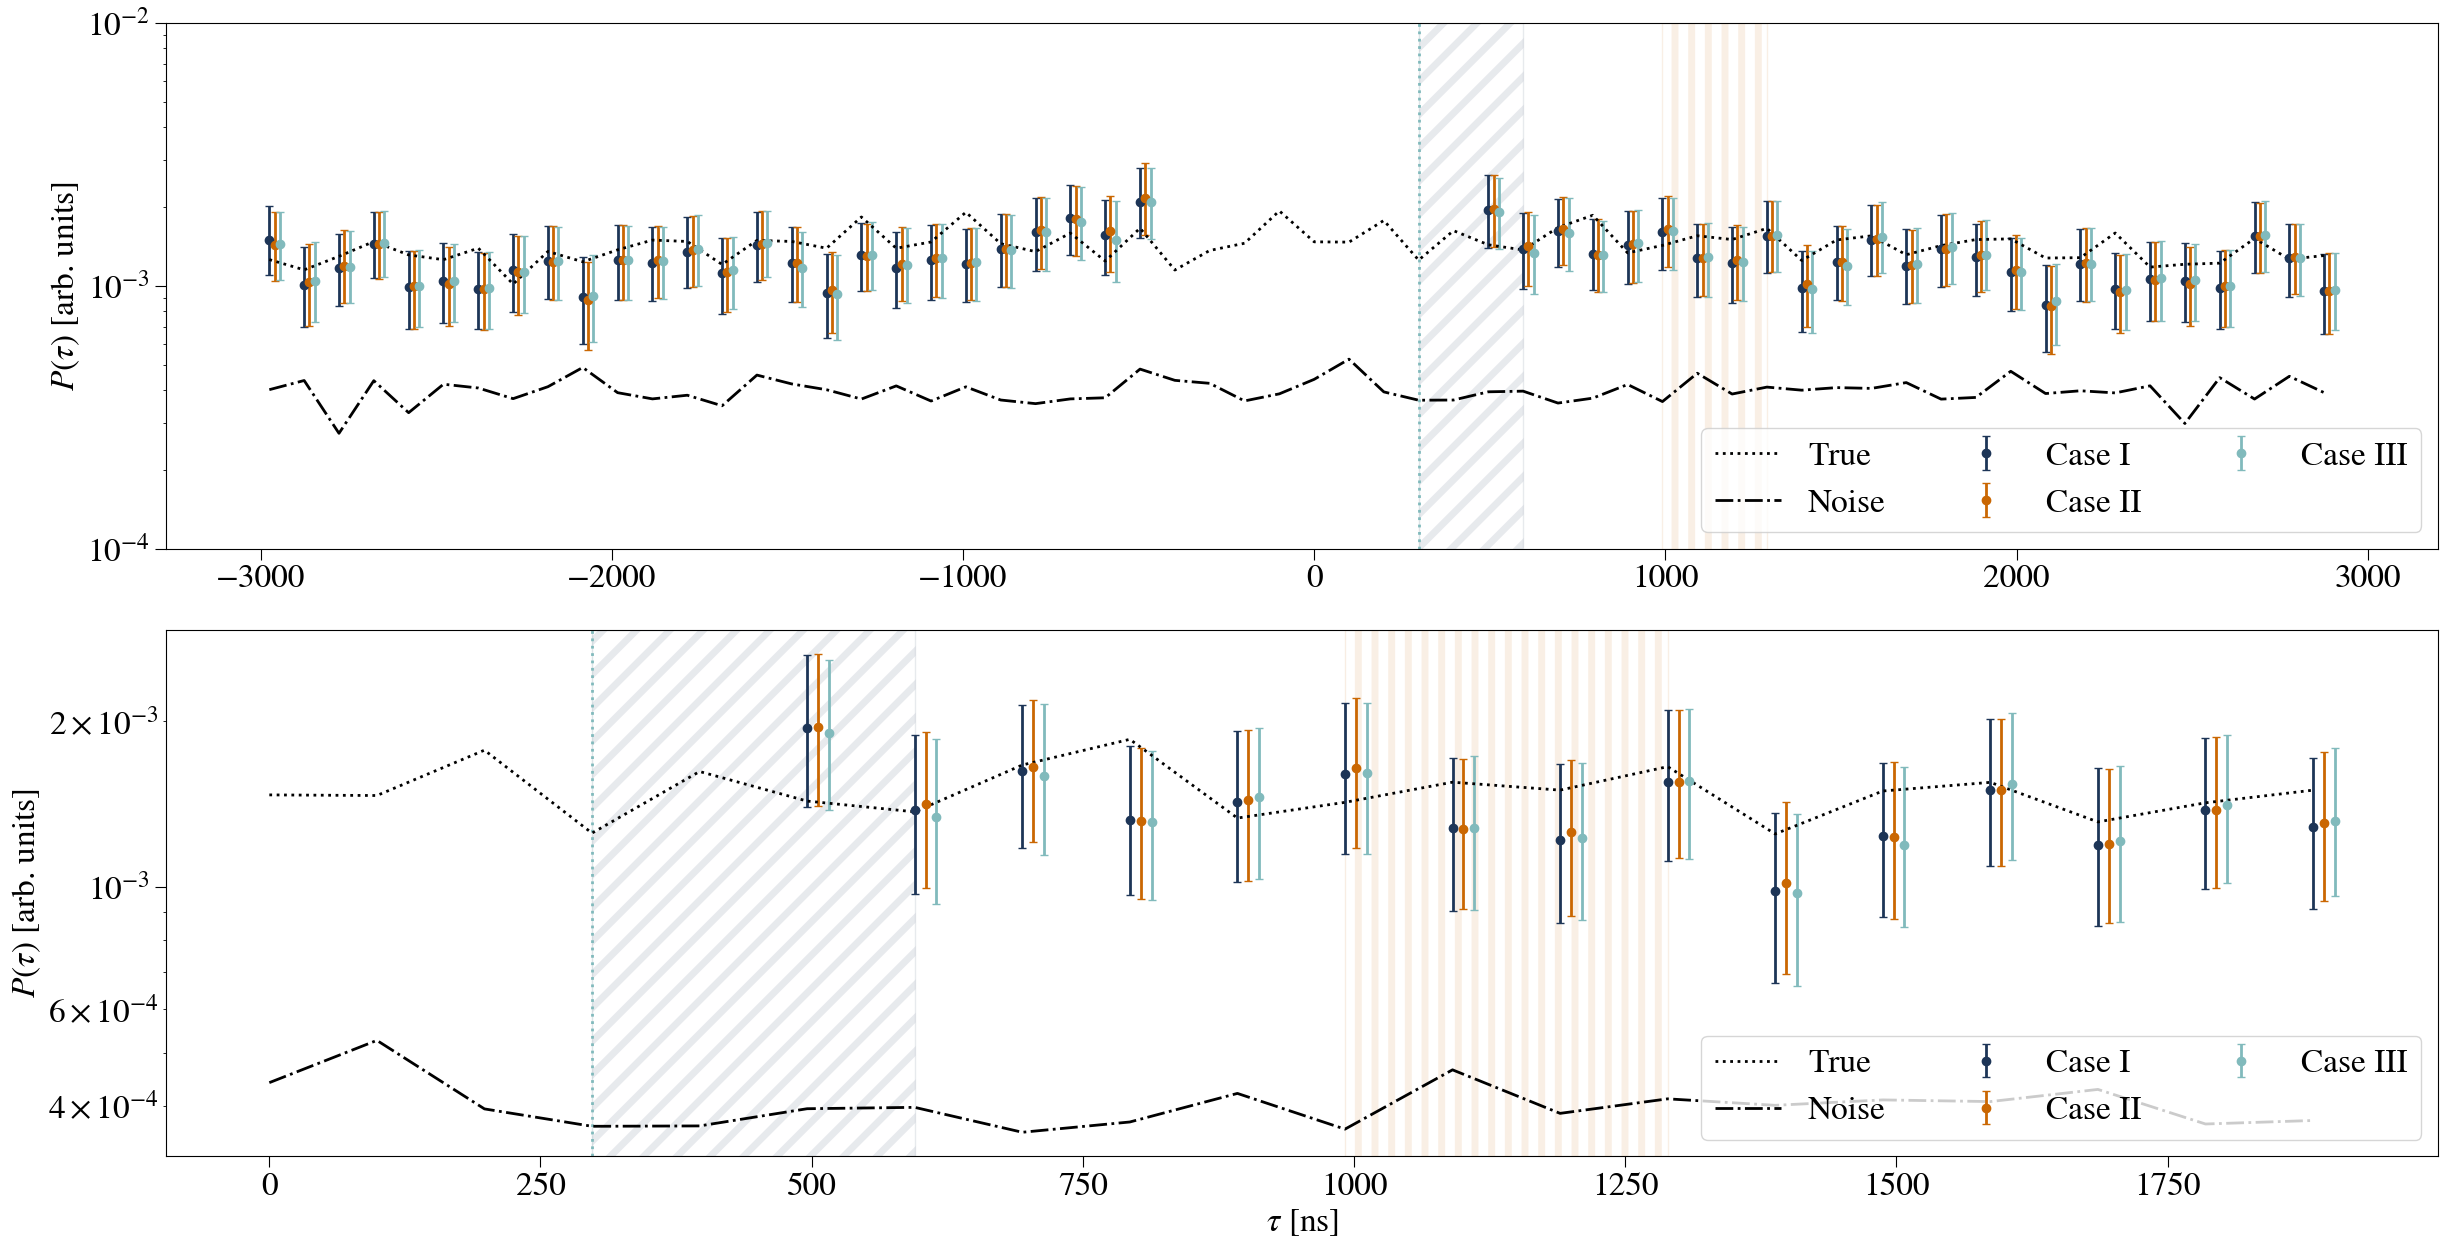

In [32]:
'''Plotting fig_11 and fig 10 together'''

# run_version_arr = ['masked_data','high_dl_fr_0','low_dl_low_fr']
result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/'

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)

fig, ax = plt.subplots(2,1,figsize=(25, 13))

i=0
fig_labels=['I','II','III','Residuals']
rm = np.arange(27,35)
keep = np.ones(60,dtype=bool)
keep[rm]=False

hatches=['/','|','.']
for run_version in run_version_arr:
    eor_true=np.load(result_dir+run_version+'/eor_true.npy')
    ps_sample = np.load(result_dir+run_version+'/dps-eor.npy')
    ln_post = np.load(result_dir+run_version+'/ln-post.npy')
    ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
    ps_mean = np.mean(ps_sample, axis=0)

    sys_delays= delays[np.unique(dl_inds[i])+int(Nfreqs/2)].value
    if Nburn > 0:
        ps_sample = ps_sample[Nburn:]
        ln_post = ln_post[Nburn:]
    # Posterior-weighted mean delay power spectrum
    dps_eor_hp_pwm = np.average(ps_sample, weights=ln_post, axis=0)
    
    # Confidence interval of delay power spectrum posteriors
    percentile = conf_interval/2 + 50
    dps_eor_hp_ubound = np.percentile(ps_sample, percentile, axis=0)
    dps_eor_hp_lbound = np.percentile(ps_sample, 100-percentile, axis=0)
    dps_eor_hp_err = np.vstack((
        dps_eor_hp_pwm - dps_eor_hp_lbound,
        dps_eor_hp_ubound - dps_eor_hp_pwm
    ))
    
    ax[0].errorbar(
                    delays.value+i*15,
                    dps_eor_hp_pwm,
                    yerr=np.abs(dps_eor_hp_err),
                    color=colors[i],
                    ls="",
                    marker="o",
                    elinewidth=2,
                    capsize=3,
                    label=f"Case "+fig_labels[i]
                    )
    
    x0, x1 = np.min(sys_delays), np.max(sys_delays)   # the x-range to shade
    ax[0].axvspan(x0, x1, facecolor='none',ec=colors[i],hatch=hatches[i], hatch_linewidth=5,alpha=0.1, zorder=0.1)
    ax[-1].axvspan(x0, x1, facecolor='none',ec=colors[i],hatch=hatches[i], hatch_linewidth=5,alpha=0.1, zorder=0.1)

    if i==2:
        for dl in sys_delays:
            ax[0].axvline(dl,ls='dotted',c=colors[i],lw=2)
            ax[-1].axvline(dl,ls='dotted',c=colors[i],lw=2)

    ax[-1].errorbar(
                        delays[35:50].value+i*10,
                        dps_eor_hp_pwm[35:50],
                        yerr=np.abs(dps_eor_hp_err[:,35:50]),
                        color=colors[i],
                        ls="",
                        marker="o",
                        elinewidth=2,
                        capsize=3,
                        label=f"Case "+fig_labels[i]
                        )
    # ax[-1].grid()
    print(max((dps_eor_hp_pwm-ps_true)/ps_true))
    i=i+1

ax[-1].set_ylabel(r"$P(\tau)$ [arb. units]")
ax[-1].set_xlabel(r'$\tau$ [ns]')
ax[-1].axhline(0,ls='dotted')
ax[-1].plot(delays[30:50], ps_true[30:50], "k:", label="True",lw=2)
ax[-1].plot(delays[30:50],calc_ps(n.T)[30:50],'k',ls='-.',label='Noise',lw=2)
ax[-1].legend(loc="lower right",ncol=3)

ax[-1].set_yscale('log')
ax[0].plot(delays, ps_true, "k:", label="True",lw=2)
ax[0].plot(delays,calc_ps(n.T),'k',ls='-.',label='Noise',lw=2)
ax[0].legend(loc="lower right",ncol=3)
ax[0].set_ylabel(r"$P(\tau)$ [arb. units]")
ax[0].set_ylim(1e-4,1e-2)
# ax.set_title("EoR Delay Power Spectrum Comparison")
ax[0].set_yscale("log")
# ax[i].grid()

for a in ax.flatten():
    a.tick_params(length=8)
fig.tight_layout()

plt.savefig(fig_dir+'/delay_power_spectrum_combined.pdf',bbox_inches='tight',dpi=300)

## Old figure

0.3588923290337428
0.3626835648220177
0.32925538672889954


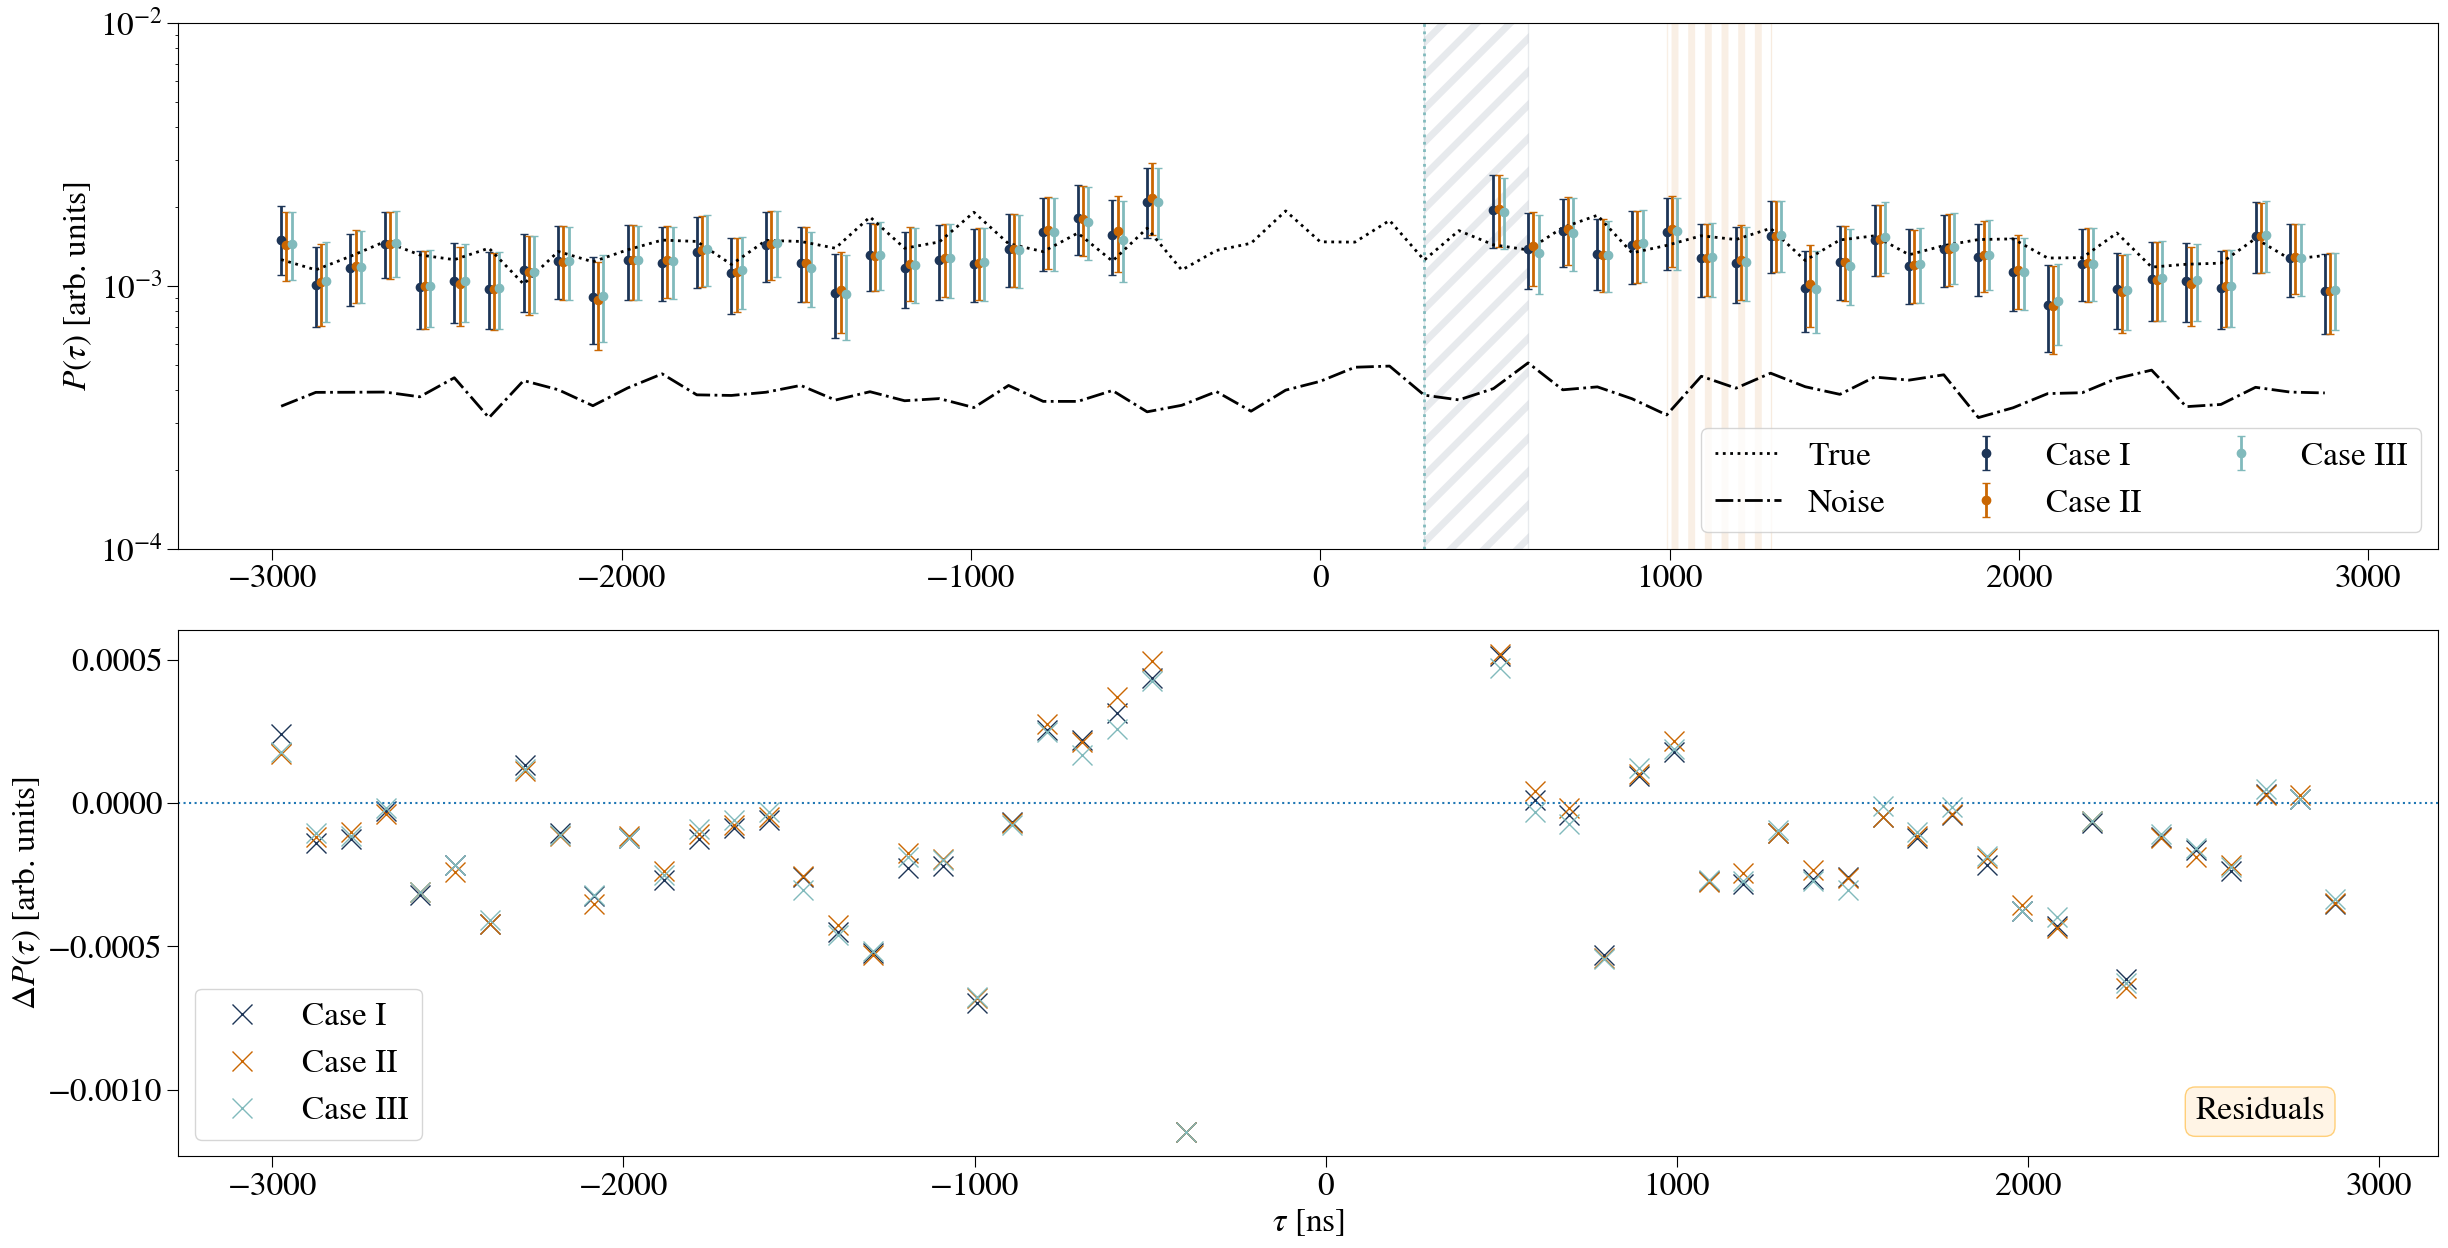

In [ ]:
# run_version_arr = ['masked_data','high_dl_fr_0','low_dl_low_fr']
result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/'

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)

fig, ax = plt.subplots(2,1,figsize=(25, 13))

i=0
fig_labels=['I','II','III','Residuals']
rm = np.arange(27,35)
keep = np.ones(60,dtype=bool)
keep[rm]=False

hatches=['/','|','.']
for run_version in run_version_arr:
    eor_true=np.load(result_dir+run_version+'/eor_true.npy')
    ps_sample = np.load(result_dir+run_version+'/dps-eor.npy')
    ln_post = np.load(result_dir+run_version+'/ln-post.npy')
    ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
    ps_mean = np.mean(ps_sample, axis=0)

    sys_delays= delays[np.unique(dl_inds[i])+int(Nfreqs/2)].value
    if Nburn > 0:
        ps_sample = ps_sample[Nburn:]
        ln_post = ln_post[Nburn:]
    # Posterior-weighted mean delay power spectrum
    dps_eor_hp_pwm = np.average(ps_sample, weights=ln_post, axis=0)
    
    # Confidence interval of delay power spectrum posteriors
    percentile = conf_interval/2 + 50
    dps_eor_hp_ubound = np.percentile(ps_sample, percentile, axis=0)
    dps_eor_hp_lbound = np.percentile(ps_sample, 100-percentile, axis=0)
    dps_eor_hp_err = np.vstack((
        dps_eor_hp_pwm - dps_eor_hp_lbound,
        dps_eor_hp_ubound - dps_eor_hp_pwm
    ))
    
    ax[0].errorbar(
                    delays.value+i*15,
                    dps_eor_hp_pwm,
                    yerr=np.abs(dps_eor_hp_err),
                    color=colors[i],
                    ls="",
                    marker="o",
                    elinewidth=2,
                    capsize=3,
                    label=f"Case "+fig_labels[i]
                    )
    
    x0, x1 = np.min(sys_delays), np.max(sys_delays)   # the x-range to shade
    ax[0].axvspan(x0, x1, facecolor='none',ec=colors[i],hatch=hatches[i], hatch_linewidth=5,alpha=0.1, zorder=0.1)
    # ax[-1].axvspan(x0, x1, color=colors[i], alpha=0.1, ec=None, zorder=0.1)

    if i==2:
        for dl in sys_delays:
            ax[0].axvline(dl,ls='dotted',c=colors[i],lw=2)

    ax[-1].plot(delays[keep],(dps_eor_hp_pwm[keep]-ps_true[keep]),'x',color=colors[i],label=f"Case "+fig_labels[i],ms=15)
    ax[-1].set_ylabel(r"$\Delta P(\tau)$ [arb. units]")
    ax[-1].set_xlabel(r'$\tau$ [ns]')
    ax[-1].legend()
    # ax[-1].grid()
    print(max((dps_eor_hp_pwm-ps_true)/ps_true))
    i=i+1
ax[-1].text(0.95,0.07,fig_labels[-1], bbox=bbox,
            transform=ax[-1].transAxes, horizontalalignment='right')
ax[-1].axhline(0,ls='dotted')

ax[0].plot(delays, ps_true, "k:", label="True",lw=2)
ax[0].plot(delays,calc_ps(n.T),'k',ls='-.',label='Noise',lw=2)
ax[0].legend(loc="lower right",ncol=3)
ax[0].set_ylabel(r"$P(\tau)$ [arb. units]")
ax[0].set_ylim(1e-4,1e-2)
# ax.set_title("EoR Delay Power Spectrum Comparison")
ax[0].set_yscale("log")
# ax[i].grid()

for a in ax.flatten():
    a.tick_params(length=8)
fig.tight_layout()

# plt.savefig(fig_dir+'/delay_power_spectrum_full.pdf',bbox_inches='tight',dpi=300)

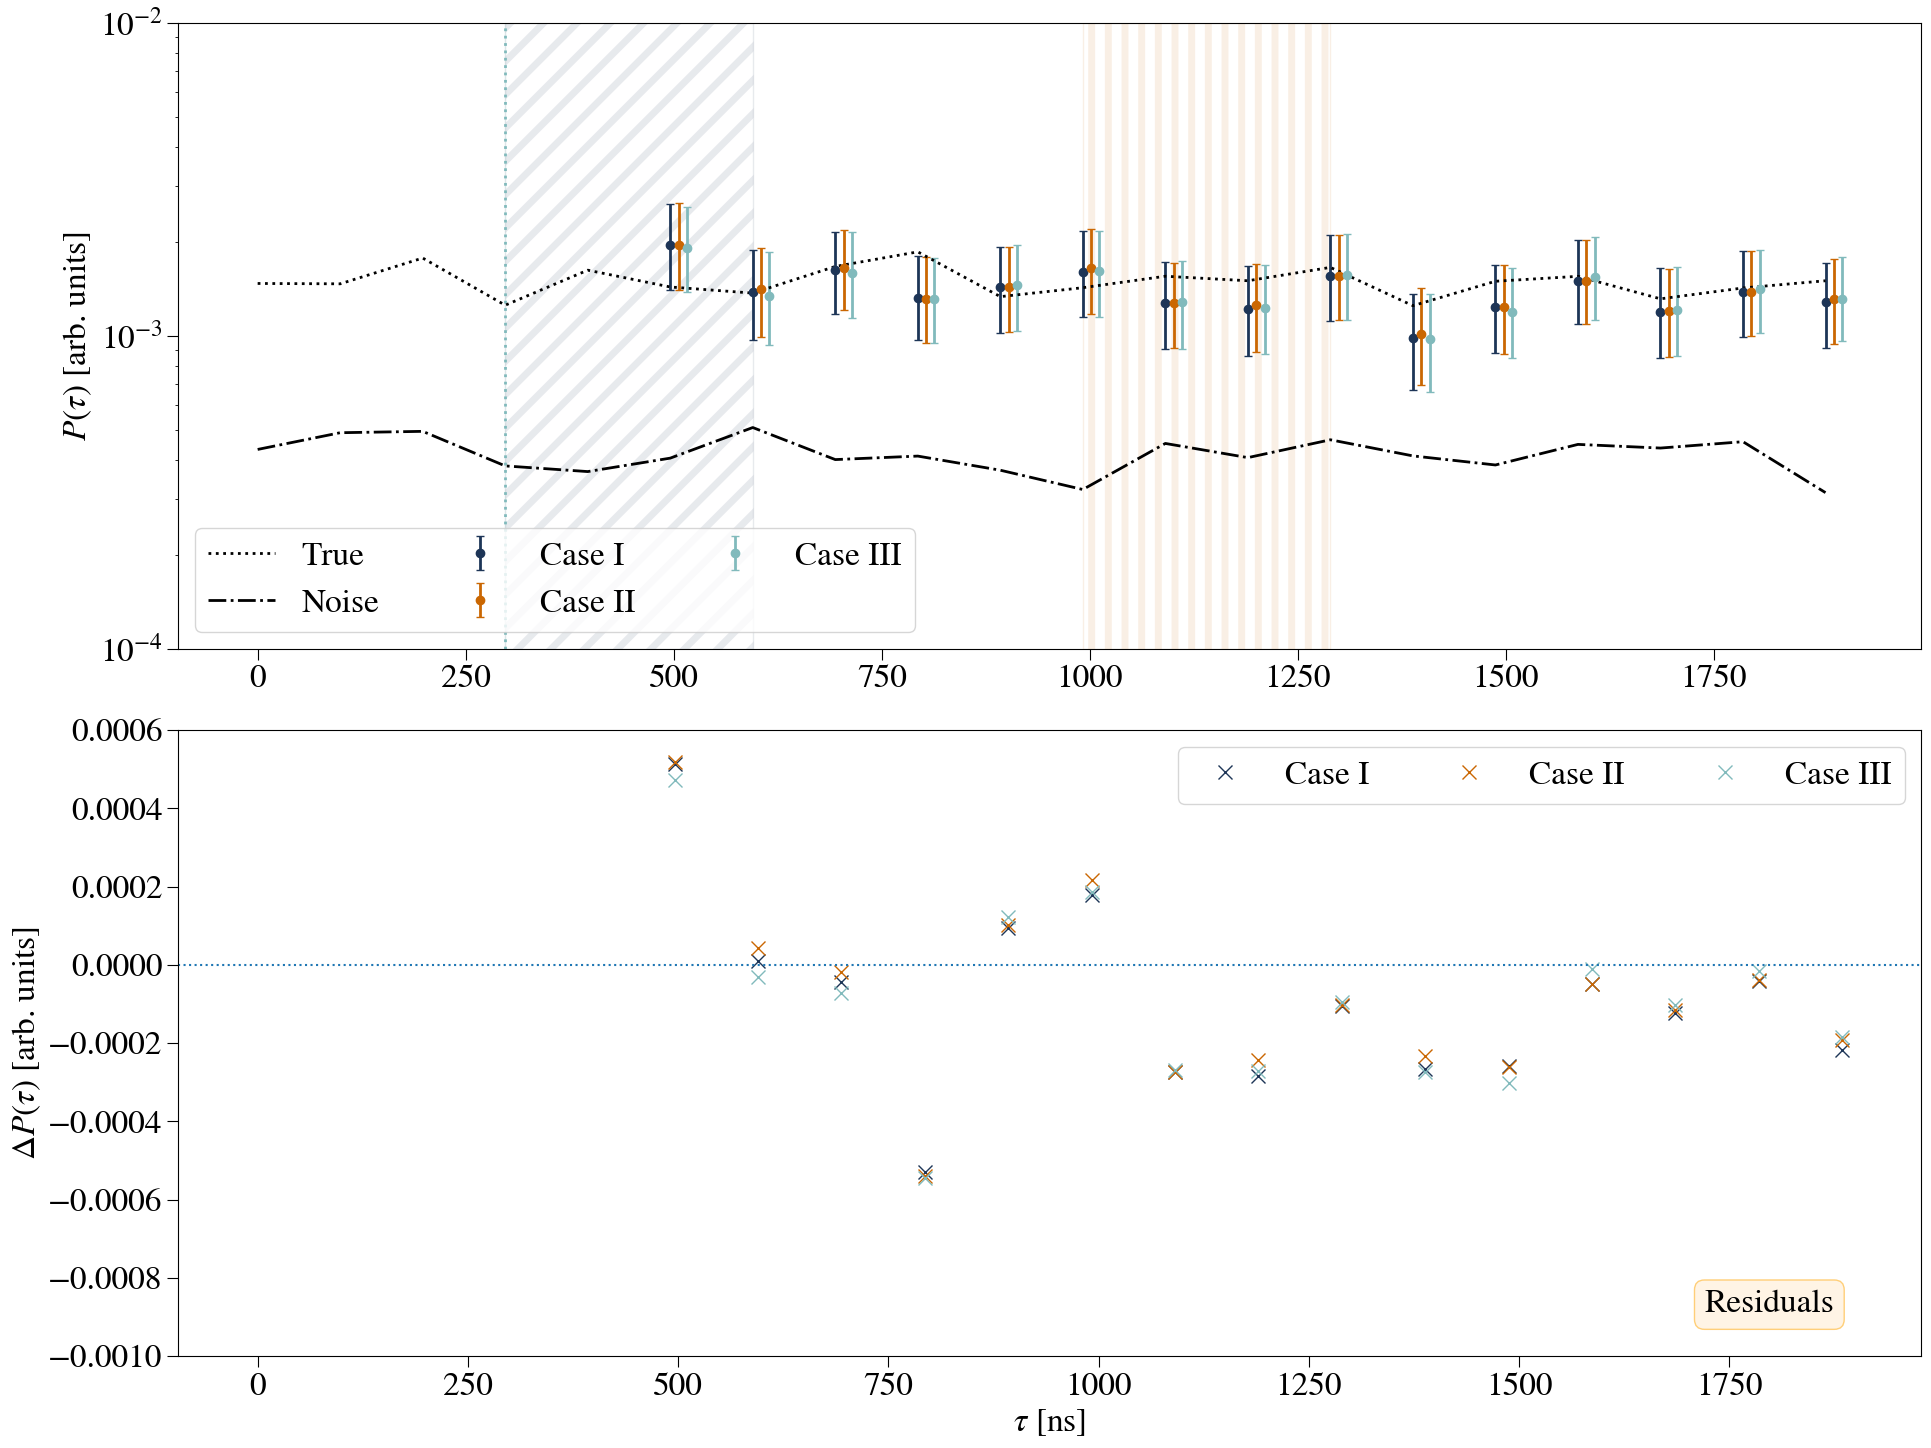

In [ ]:

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)

fig, ax = plt.subplots(2,1,figsize=(20, 15))
i=0
fig_labels=['I','II','III','Residuals']
for run_version in run_version_arr:
    eor_true=np.load(result_dir+'high_dl_fr_0/eor_true.npy')
    ps_sample = np.load(result_dir+run_version+'/dps-eor.npy')
    ln_post = np.load(result_dir+run_version+'/ln-post.npy')
    ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
    ps_mean = np.mean(ps_sample, axis=0)
    df = (freqs[1] - freqs[0]) * u.MHz
    delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to("1/ns")))

 
    sys_delays= delays[np.unique(dl_inds[i])+int(Nfreqs/2)].value
    if Nburn > 0:
        ps_sample = ps_sample[Nburn:]
        ln_post = ln_post[Nburn:]
    # Posterior-weighted mean delay power spectrum
    dps_eor_hp_pwm = np.average(ps_sample, weights=ln_post, axis=0)
    
    # Confidence interval of delay power spectrum posteriors
    percentile = conf_interval/2 + 50
    dps_eor_hp_ubound = np.percentile(ps_sample, percentile, axis=0)
    dps_eor_hp_lbound = np.percentile(ps_sample, 100-percentile, axis=0)
    dps_eor_hp_err = np.vstack((
        dps_eor_hp_pwm - dps_eor_hp_lbound,
        dps_eor_hp_ubound - dps_eor_hp_pwm
    ))
    
    ax[0].errorbar(
                    delays[30:50].value+i*10,
                    dps_eor_hp_pwm[30:50],
                    yerr=np.abs(dps_eor_hp_err[:,30:50]),
                    color=colors[i],
                    ls="",
                    marker="o",
                    elinewidth=2,
                    capsize=3,
                    label=f"Case "+fig_labels[i]
                    )
    
    x0, x1 = np.min(sys_delays), np.max(sys_delays)   # the x-range to shade
    ax[0].axvspan(x0, x1, facecolor='none',ec=colors[i],hatch=hatches[i], hatch_linewidth=5,alpha=0.1, zorder=0.1)
    # ax[-1].axvspan(x0, x1, color=colors[i], alpha=0.1, ec=None, zorder=0.1)

    if i==2:
        for dl in sys_delays:
            ax[0].axvline(dl,ls='dotted',c=colors[i],lw=2)

    ax[-1].plot(delays[30:50],(dps_eor_hp_pwm-ps_true)[30:50],'x',color=colors[i],label=f"Case "+fig_labels[i],lw=2,ms=10)
    ax[-1].set_ylabel(r"$\Delta P(\tau)$ [arb. units]")
    ax[-1].set_xlabel(r'$\tau$ [ns]')
    ax[-1].legend(ncol=3)
    # ax[-1].grid()

    i=i+1
ax[-1].text(0.95,0.07,fig_labels[-1], bbox=bbox,
            transform=ax[-1].transAxes, horizontalalignment='right')
ax[-1].axhline(0,ls='dotted')
ax[-1].set_ylim(-0.001,0.0006)
ax[0].plot(delays[30:50], ps_true[30:50], "k:", label="True",lw=2)
ax[0].plot(delays[30:50],calc_ps(n.T)[30:50],'k',ls='-.',label='Noise',lw=2)
ax[0].legend(loc="lower left",ncol=3)
ax[0].set_ylabel(r"$P(\tau)$ [arb. units]")
ax[0].set_ylim(1e-4,1e-2)
# ax.set_title("EoR Delay Power Spectrum Comparison")
ax[0].set_yscale("log")
# ax[i].grid()

for a in ax.flatten():
    a.tick_params(length=8)
fig.tight_layout()

# plt.savefig(fig_dir+'/delay_power_spectrum.pdf',bbox_inches='tight',dpi=300)


# Case III plots

paper_plots/low_dl_fr_20 //
10k iterations //
1e-7 bound //
0.0004 noise //
True sys start 

##  Loading data

In [7]:
'''Loading Data'''
# result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/1e7_bound/10modes'
result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/low_dl_fr_20'

fg_true=np.load(result_dir+'/fg_true.npy')
# fg_true=np.load(result_dir+'/fg_true_fit.npy') #For FG fit
fgmodes=np.load(result_dir+'/fgmodes.npy') # Only for fg_fit
fg_amps_gcr = np.load(result_dir+'/fg-amps.npy')

eor_true=np.load(result_dir+'/eor_true.npy')
eor_gcr = np.load(result_dir+'/gcr-eor.npy')
ps_sample = np.load(result_dir+'/dps-eor.npy')
ln_post = np.load(result_dir+'/ln-post.npy')

b_sys_gcr = np.load(result_dir+'/b-sys.npy')
sys_model_true = np.load(result_dir+'/gain_true.npy')
delta_g_true = (sys_modes_operator @ sys_amps_true).reshape([Nfreqs,Ntimes]).T

sky_true = eor_true + fg_true
data_true = np.load(result_dir+'/data_true.npy')

'''Getting power spectra'''
ps_fg=np.empty(ps_sample.shape)
ps_sys=np.empty(ps_sample.shape)
ps_del_g=np.empty(ps_sample.shape)
ps_data=np.empty(ps_sample.shape)

for i in range(len(ps_sample)):
    sys_model = (sys_modes_operator @ b_sys_gcr[i,:]).reshape([Nfreqs,Ntimes]).T
    data_model = (1+sys_model) * (eor_gcr[i,:,:] + (fgmodes[:,:Nfgmodes] @ fg_amps_gcr[i,:].T).T)
    ps_data[i] = calc_ps(data_model)
    ps_fg[i] = calc_ps((fgmodes[:,:Nfgmodes] @ fg_amps_gcr[i,:].T).T)
    ps_sys[i] = calc_ps(1+sys_model)
    ps_del_g[i] = calc_ps(sys_model)

eor_pspec_avg = np.mean(ps_sample,axis=0)
fg_pspec_avg = np.mean(ps_fg,axis=0)
sys_pspec_avg = np.mean(ps_sys,axis=0)
data_pspec_avg = np.mean(ps_data,axis=0)
delg_pspec_avg = np.mean(ps_del_g,axis=0)

eor_pspec_true = calc_ps(eor_true)
fg_pspec_true =  calc_ps(fg_true)
sys_pspec_true = calc_ps(sys_model_true)
n_pspec = calc_ps(n.T)
data_pspec_true = calc_ps(data_true)

b_sys_mean = np.mean(b_sys_gcr,axis=0)

'''Getting some DLFR visibilities'''
sky_true_dlfr=data_dly_fr(sky_true,freqs*1e6, lsts, windows='blackman-harris')
sys_model_true_dlfr = data_dly_fr(sys_model_true,freqs*1e6, lsts, windows='blackman-harris')
delta_g_dlfr_true = data_dly_fr(delta_g_true,freqs*1e6, lsts, windows='blackman-harris')
data_true_dlfr = data_dly_fr(data_true,freqs*1e6, lsts, windows='blackman-harris')

In [8]:
from pyuvdata import UVData

uvd=UVData()
# antpairpols=uvd.Nants_data()
uvd.read('/nvme2/scratch/sohini/hydra-pspec-systematic/test_data/vis-eor-ptsrc-gsm.uvh5', bls=[(0,1)])
print(uvd.uvw_array[0])

[ 1.46000000e+01 -2.25661267e-10 -3.79731802e-10]


## Getting sample-by-sample models

In [9]:
'''Vis Arrays'''
fg_vis_arr=np.empty([fg_amps_gcr.shape[0],Ntimes,Nfreqs],dtype='complex')
delta_g_arr = np.empty([Niter,Ntimes,Nfreqs],dtype='complex')

'''DLFR Arrays'''
eor_dlfr_arr=np.empty(eor_gcr.shape,dtype='complex')
sky_dlfr_arr=np.empty(eor_gcr.shape,dtype='complex')
delta_g_dlfr_arr = np.empty([Niter,Ntimes,Nfreqs],dtype='complex')
sys_model_dlfr_arr = np.empty([Niter,Ntimes,Nfreqs],dtype='complex')


print("Foregrounds...")
for i in tqdm(range(fg_amps_gcr.shape[0])):
    fg_vis_arr[i,:,:] = (fgmodes @ fg_amps_gcr[i,:].T).T

print("Sky DLFR...")
for i in tqdm(range(len(eor_gcr))):
    eor_dlfr_arr[i,:,:]=data_dly_fr(eor_gcr[i,:,:],freqs*1e6, lsts, windows='blackman-harris',)
    sky_dlfr_arr[i,:,:] = data_dly_fr(eor_gcr[i,:,:]+fg_vis_arr[i,:,:],freqs*1e6, lsts, windows='blackman-harris',)

print("Systematics...")
for i in tqdm(range(Niter)):
    delta_g_arr[i,:,:] = (sys_modes_operator @ b_sys_gcr[i,:]).reshape([Nfreqs,Ntimes]).T
    delta_g_dlfr_arr[i,:,:] = data_dly_fr(delta_g_arr[i,:,:],freqs*1e6, lsts, windows='blackman-harris')
    sys_model_dlfr_arr[i,:,:] = data_dly_fr(1+delta_g_arr[i,:,:],freqs*1e6, lsts, windows='blackman-harris')

delta_g_dlfr_mean = delta_g_dlfr_arr.mean(axis=0)
delta_g_dlfr_std = np.std(delta_g_dlfr_arr,axis=0)
delta_g_mean = delta_g_arr.mean(axis=0)
delta_g_std = np.std(delta_g_arr, axis=0)
sys_model_dlfr_mean   = sys_model_dlfr_arr.mean(axis=0)

mean_sky_dlfr  = sky_dlfr_arr.mean(axis=0)
mean_eor_dlfr = eor_dlfr_arr.mean(axis=0)


Foregrounds...


100%|██████████| 10000/10000 [00:00<00:00, 39113.56it/s]


Sky DLFR...


100%|██████████| 10000/10000 [00:02<00:00, 3440.96it/s]


Systematics...


100%|██████████| 10000/10000 [00:17<00:00, 588.19it/s]


## Figure 7 : Corner plot

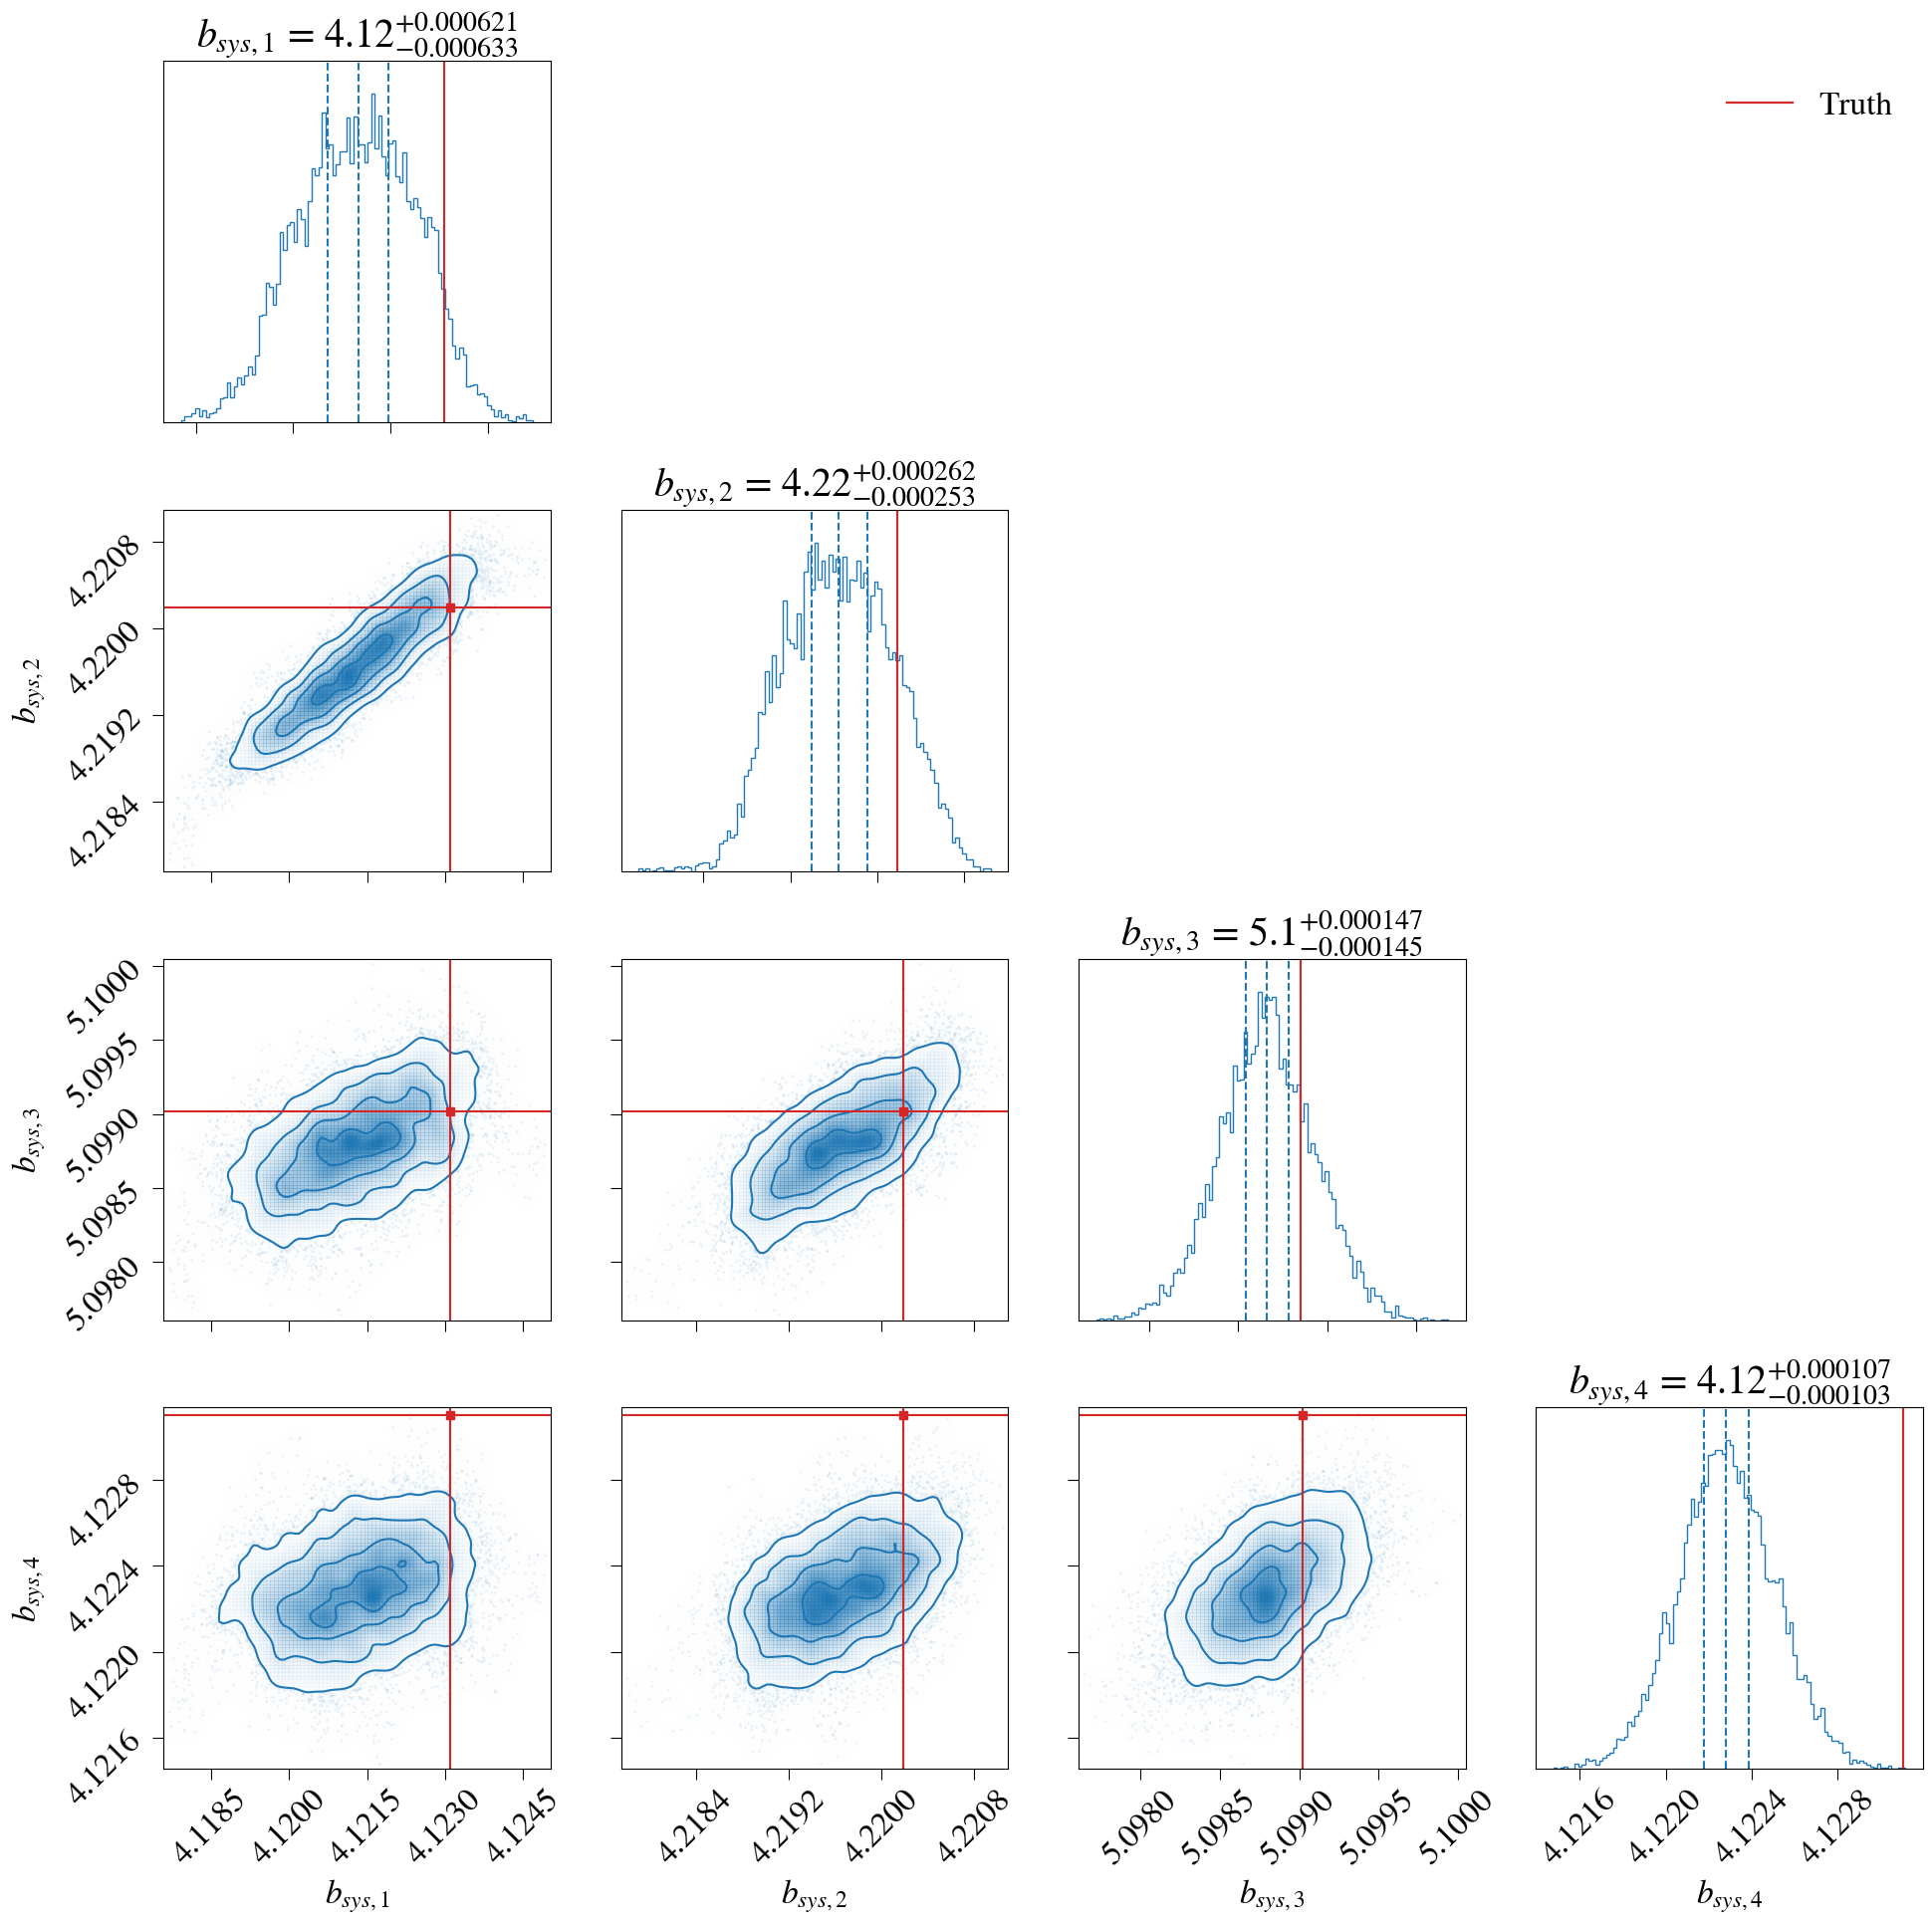

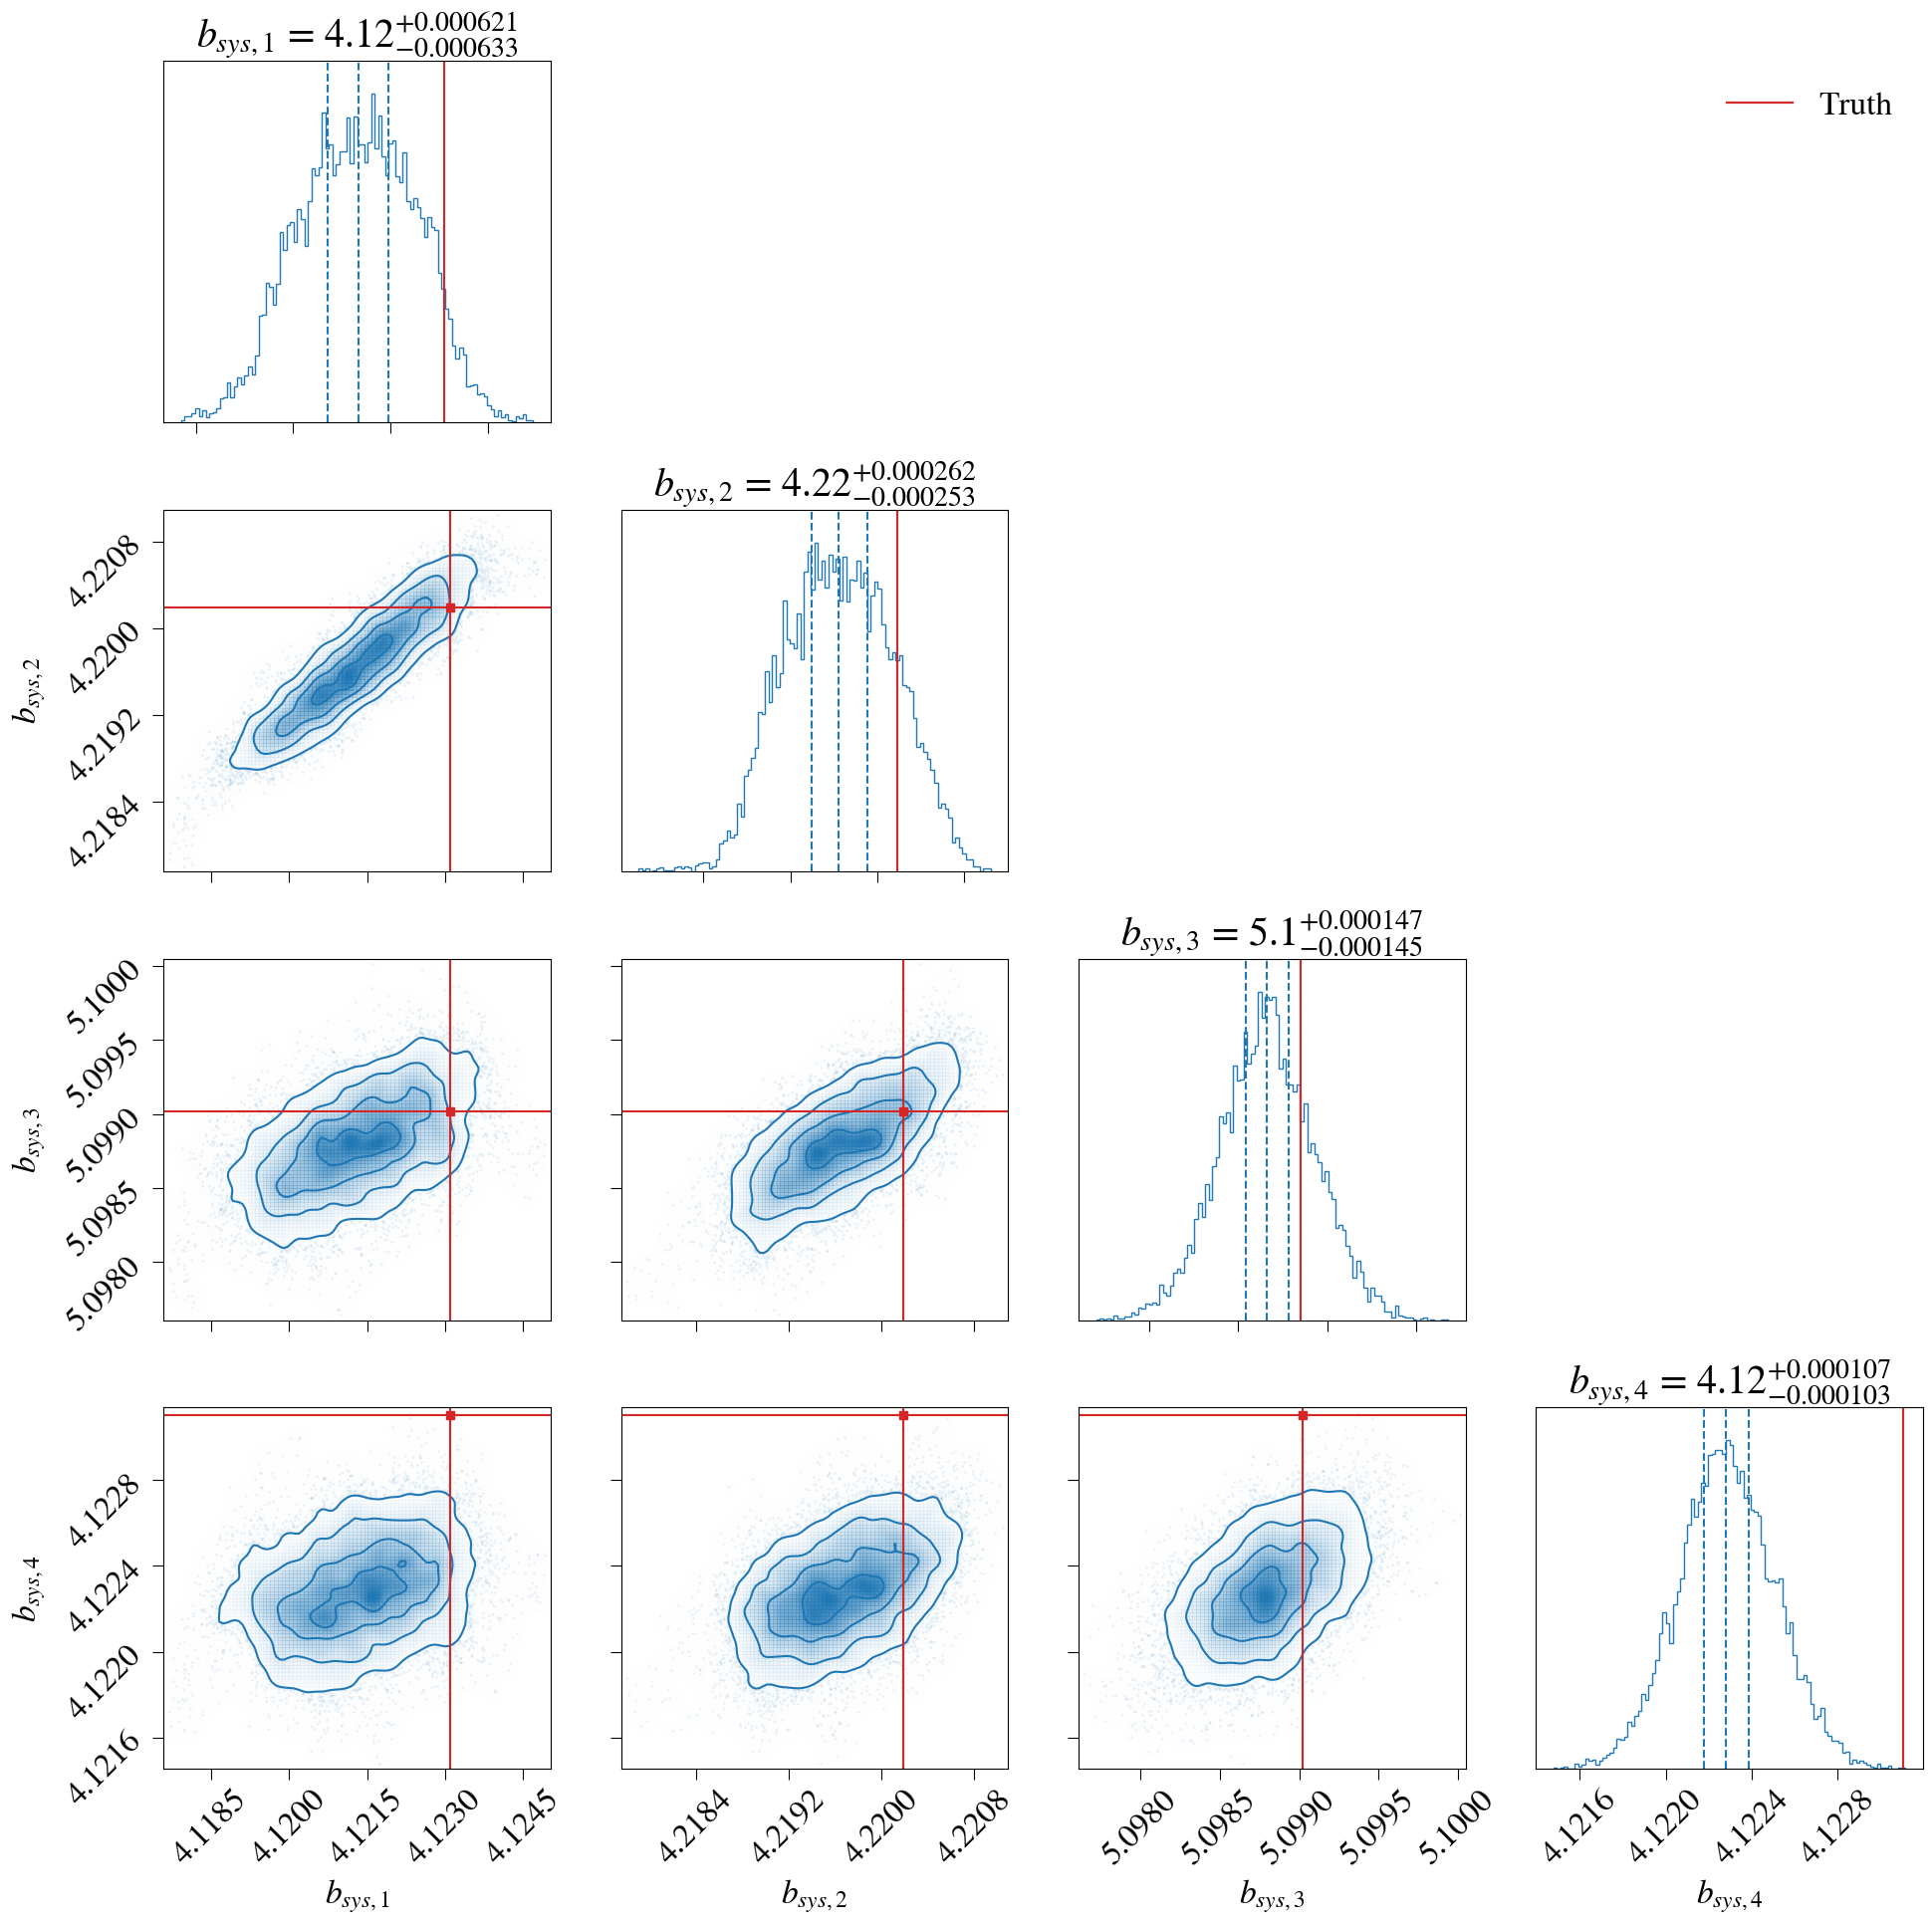

In [10]:
'''B_sys corner plots'''
def corner_plot(
    samples, labels=None, truths=None, burn=0, thin=1, fig=None,
    truths_label="Truth",
    extra_truths=None, extra_color="tab:green", extra_truths_label="Truth B",
    title=None, legend_loc="best"
):

    S = samples[burn::thin]
    ndim = S.shape[1]

    fig = corner.corner(
        S, labels=labels, truths=truths,
        truth_color="tab:red",
        quantiles=[0.32, 0.50, 0.68], fig=fig,
        show_titles=True, title_fmt=".3g",
        bins=100, smooth=2.0, color="C0",
    )

    # Optional second set of truths
    if extra_truths is not None:
        corner.overplot_lines(fig, extra_truths, color=extra_color, linewidth=1.6)
        corner.overplot_points(fig, [extra_truths], color=extra_color, marker="s", ms=5)

    # Legend (put it on the first diagonal axis)
    axes = np.array(fig.axes).reshape(ndim, ndim)
    ax0 = axes[0, -1]

    legend_handles = []
    if truths is not None:
        legend_handles.append(Line2D([0], [0], color="tab:red", lw=1.6, label=truths_label))
    if extra_truths is not None:
        legend_handles.append(Line2D([0], [0], color=extra_color, lw=1.6, label=extra_truths_label))

    if legend_handles:
        ax0.legend(handles=legend_handles, loc=legend_loc, frameon=False)

    # Overall title (optional)
    if title:
        fig.suptitle(title, y=0.98)
        fig.tight_layout(rect=(0, 0, 1, 0.96))
    else:
        fig.tight_layout()

    return fig


# usage
# samples shape: (n, 4)
fig,ax = plt.subplots(4,4,figsize=(20,20))

for a in ax.flatten():
    a.tick_params(length=8)
corner_plot(np.abs(b_sys_gcr), truths=np.abs(sys_amps_true),labels=[r"$b_{sys,1}$", r"$b_{sys,2}$", r"$b_{sys,3}$", r"$b_{sys,4}$"],fig=fig)
# plt.savefig(fig_dir+'/bsys_corner_plot.pdf',bbox_inches='tight',dpi=300)

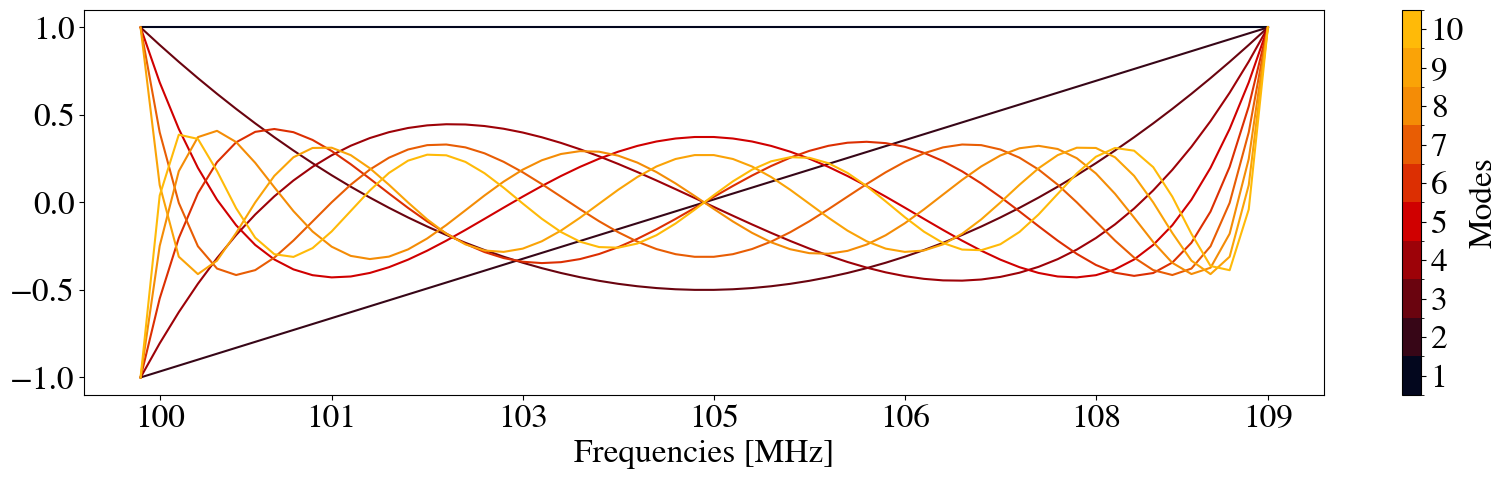

In [11]:
'''fgmodes'''
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

colors = ["#03071e","#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
cmap = ListedColormap(colors)                     # 10 discrete colors
bounds = np.arange(0.5, 10.5 + 1, 1)              # 11 edges for 10 colors
norm   = BoundaryNorm(bounds, cmap.N)

# plot using the same discrete colors
for i, col in enumerate(colors, start=1):
    ax.plot(fgmodes[:, i-1], c=col)

ax.set_xticks(xticklocs,labels=xticklabels_freqs)
ax.set_xlabel("Frequencies [MHz]")

# make a discrete colorbar with ticks at 1..10
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])                                   # required for some mpl versions
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(1, 11), label="Modes")
# plt.savefig(fig_dir+'/fgmodes.pdf',bbox_inches='tight',dpi=300)

## Figure 4: Result Waterfalls

Text(0.95, 0.07, 'Residuals (True-$\\mu$)')

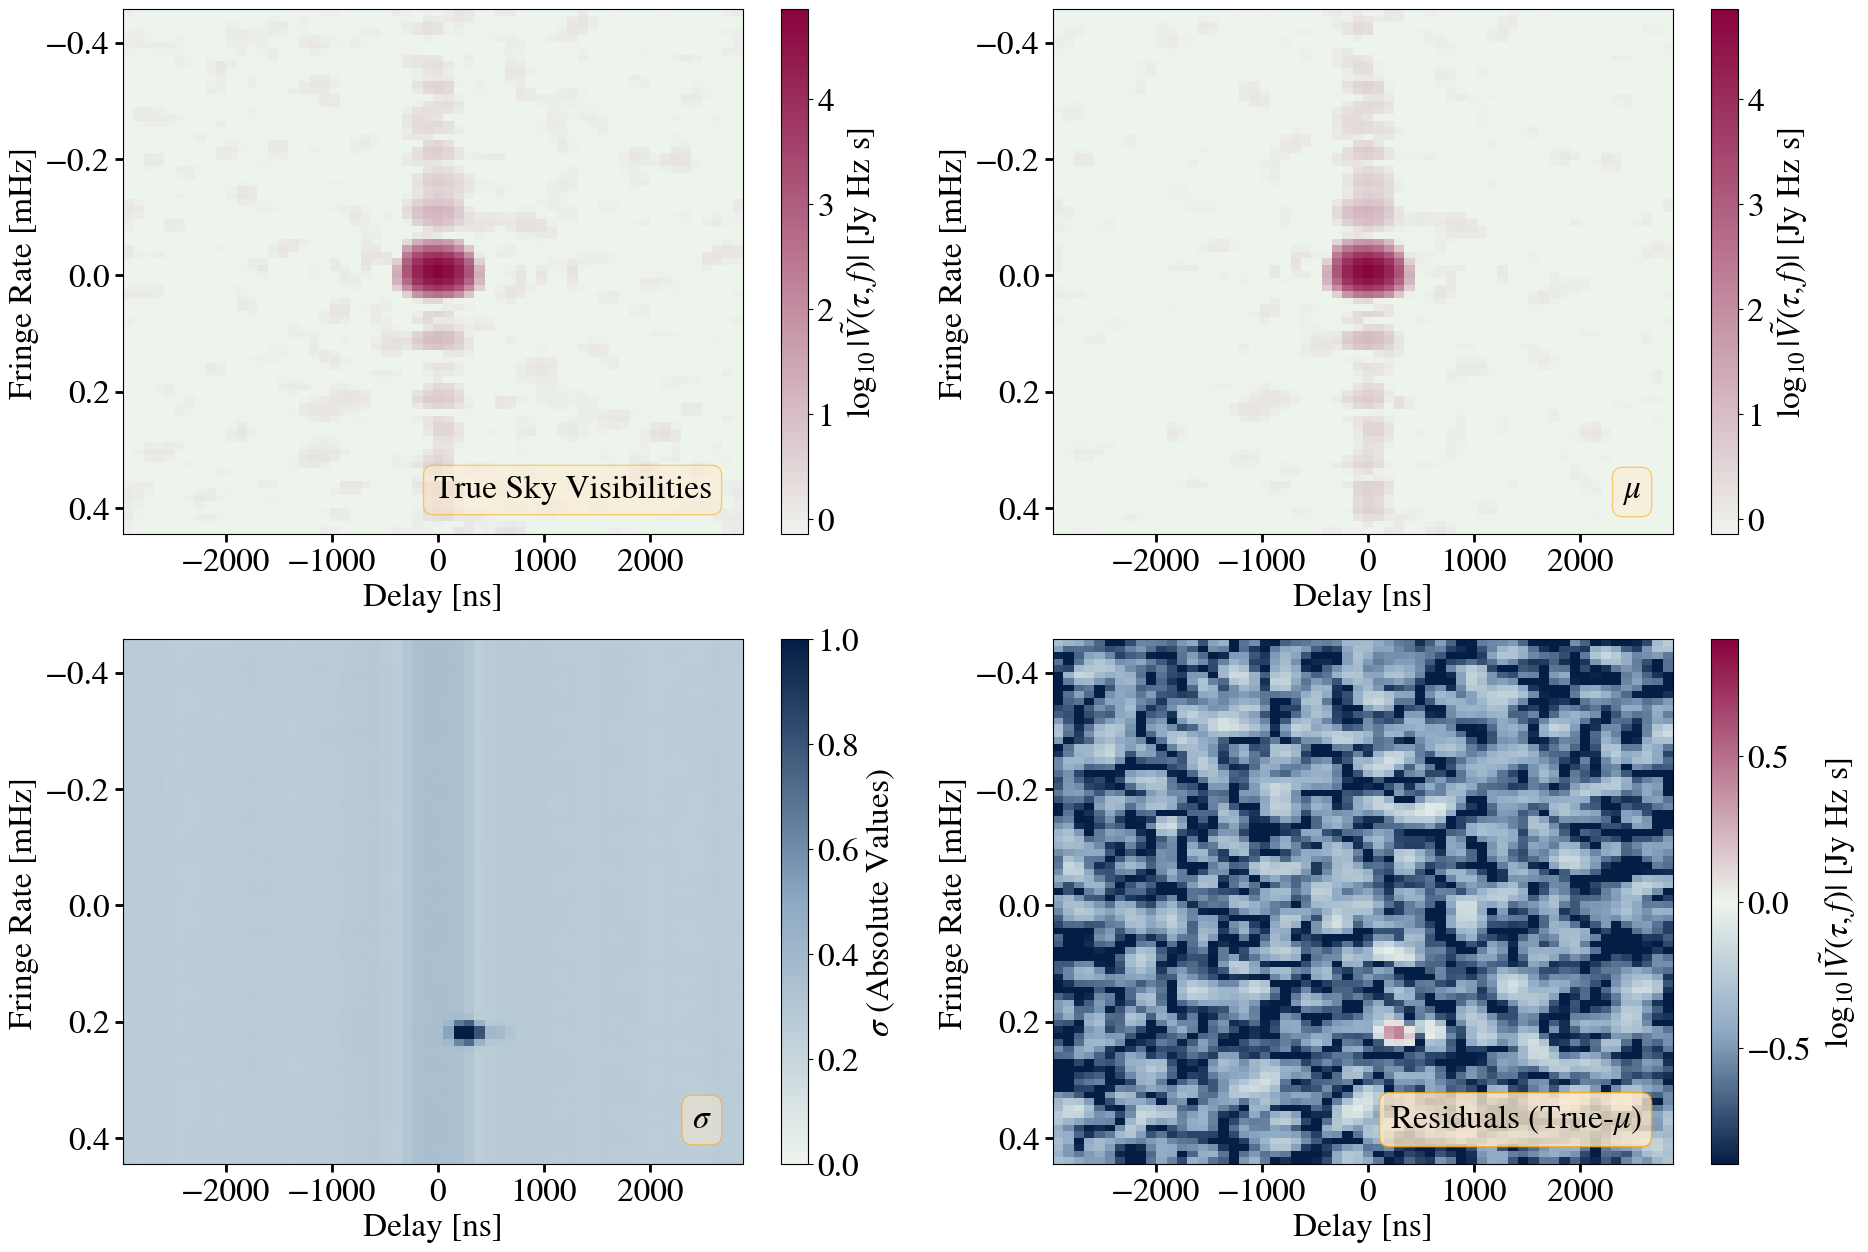

In [12]:
fig,axs=plt.subplots(2,2,figsize=(22,15))

'''True Sky'''
im1=plot_waterfalls_from_dlfr(sky_true_dlfr, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[0], mode='log', 
                vmin=None,vmax=None,cmap=paper_map_pink, dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta')
axs.flatten()[0].text(0.95,0.07,"True Sky Visibilities", bbox=bbox,
            transform=axs.flatten()[0].transAxes, horizontalalignment='right')

'''Mean Sky'''
im1=plot_waterfalls_from_dlfr(mean_sky_dlfr, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[1], mode='log', 
                vmin=None,vmax=None,cmap=paper_map_pink, dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta')
axs.flatten()[1].text(0.95,0.07,r'$\mu$', bbox=bbox,
            transform=axs.flatten()[1].transAxes, horizontalalignment='right')

'''STD Sky'''
im2=plot_waterfalls_from_dlfr(np.std(sky_dlfr_arr,axis=0), freqs*1e6, lsts, fig=fig,ax=axs.flatten()[2], mode='abs', 
                vmin=0,vmax=1,cmap=paper_map_blue, dynamic_range=None, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',cbar_label=r'$\sigma$ (Absolute Values)')
axs.flatten()[2].text(0.95,0.07,r'$\sigma$', bbox=bbox,
            transform=axs.flatten()[2].transAxes, horizontalalignment='right')

'''True - Mean'''
im3=plot_waterfalls_from_dlfr(sky_true_dlfr - mean_sky_dlfr, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[3], mode='log', 
                vmin=-0.9,vmax=0.9,cmap=paper_map, dynamic_range=None, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta')
bbox_res = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.8)
axs.flatten()[3].text(0.95,0.07,"Residuals (True-"+r'$\mu$'+")", bbox=bbox_res,
            transform=axs.flatten()[3].transAxes, horizontalalignment='right')
# plt.savefig(fig_dir+'/result_waterfalls.pdf',bbox_inches='tight',dpi=300)

## Figure 5: Systematics result waterfalls

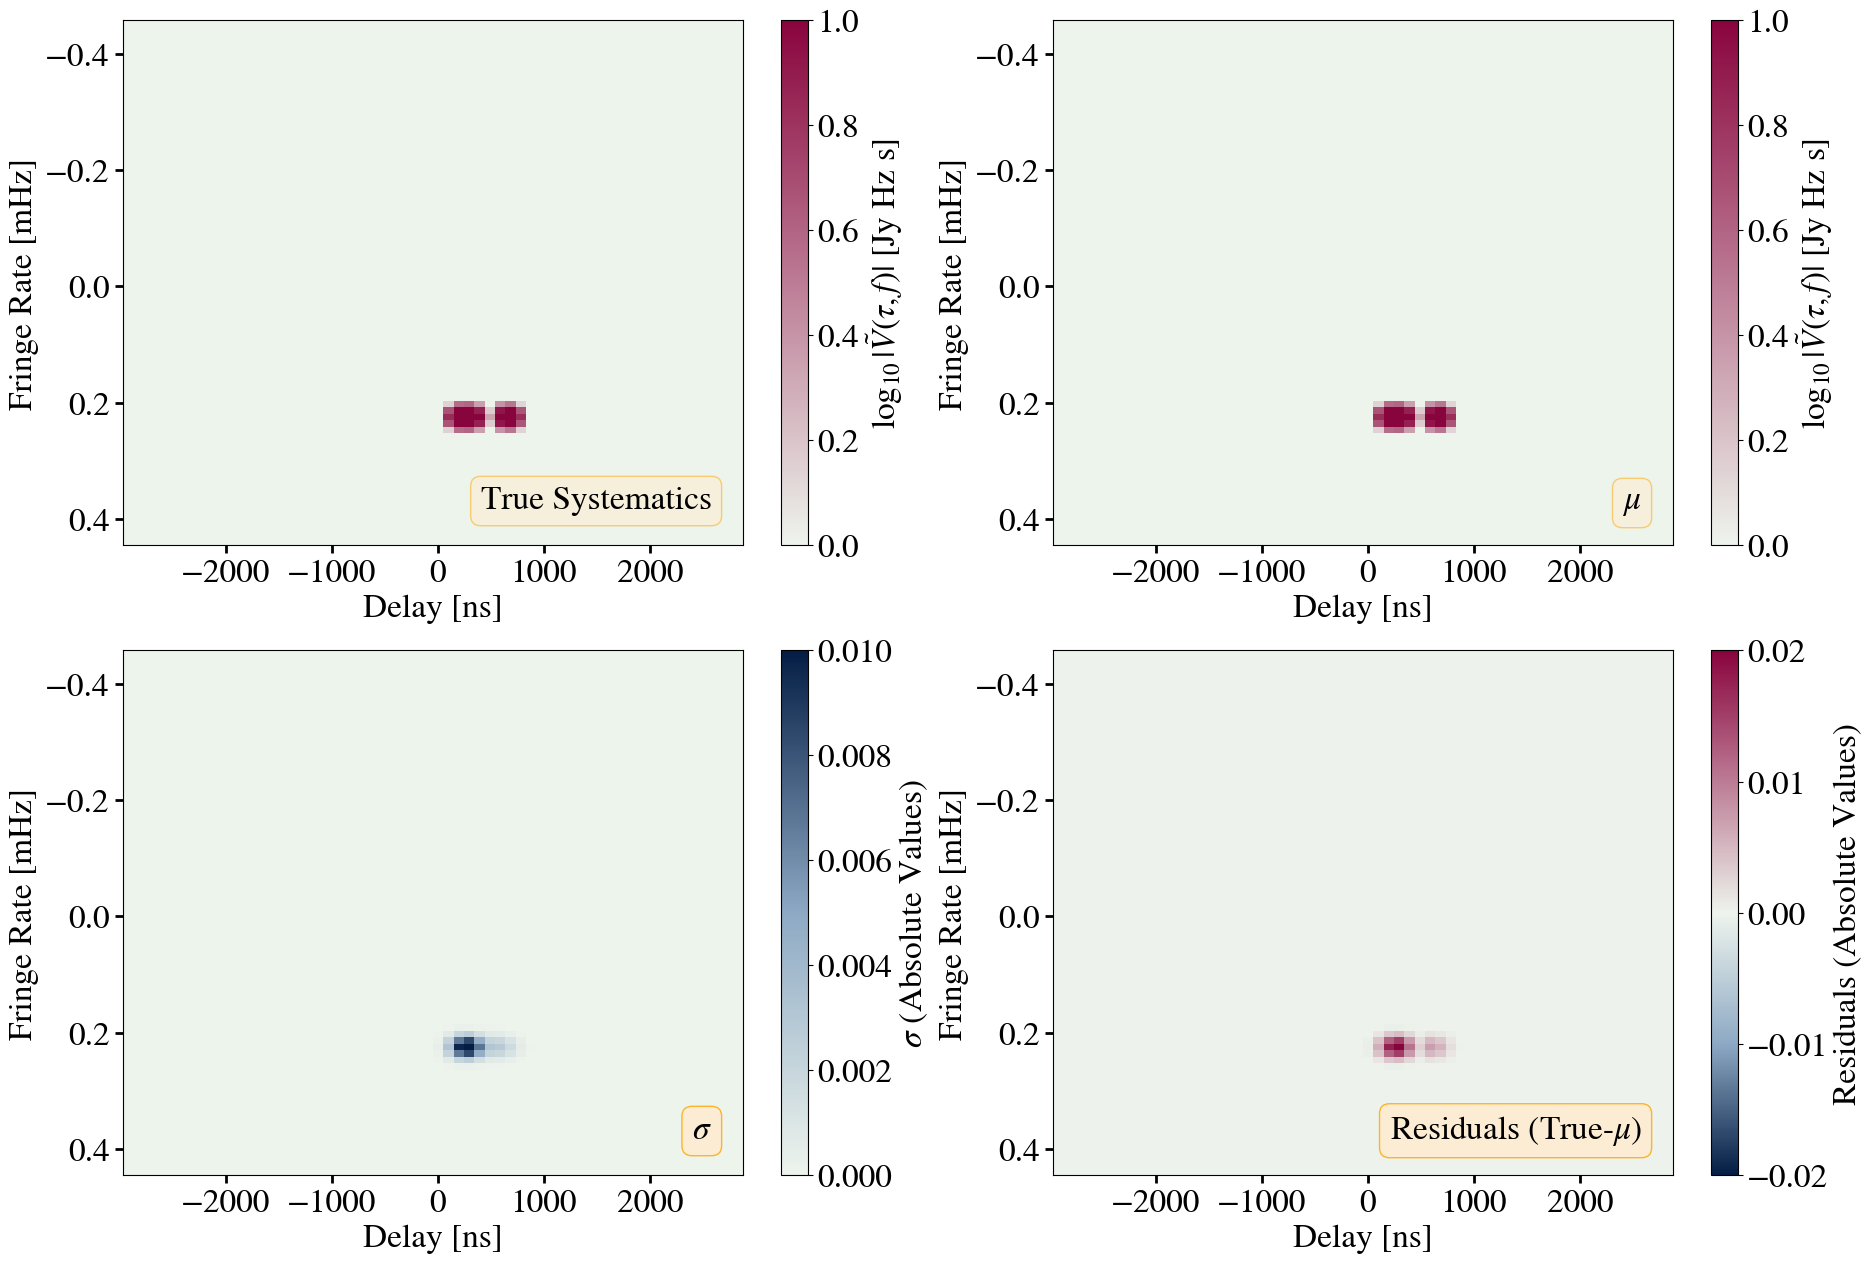

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(22,15))

'''True delta_g'''
im1=plot_waterfalls_from_dlfr(delta_g_dlfr_true, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[0], mode='log', 
                vmin=0,vmax=1,cmap=paper_map_pink, dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta')
axs.flatten()[0].text(0.95,0.07,"True Systematics", bbox=bbox,
            transform=axs.flatten()[0].transAxes, horizontalalignment='right')
'''Mean delta_g'''
im1=plot_waterfalls_from_dlfr(delta_g_dlfr_mean, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[1], mode='log', 
                vmin=0,vmax=1,cmap=paper_map_pink, dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta')
axs.flatten()[1].text(0.95,0.07,r'$\mu$', bbox=bbox,
            transform=axs.flatten()[1].transAxes, horizontalalignment='right')

'''STD delta_g'''
im2=plot_waterfalls_from_dlfr(delta_g_dlfr_std, freqs*1e6, lsts, fig=fig,ax=axs.flatten()[2], mode='abs', 
                vmin=0,vmax=0.01,cmap=paper_map_blue, dynamic_range=None, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',cbar_label=r'$\sigma$ (Absolute Values)')
axs.flatten()[2].text(0.95,0.07,r'$\sigma$', bbox=bbox_res,
            transform=axs.flatten()[2].transAxes, horizontalalignment='right')

'''True - Mean'''
im3=plot_waterfalls_from_dlfr(sys_model_true_dlfr - sys_model_dlfr_arr.mean(axis=0), freqs*1e6, lsts, fig=fig,ax=axs.flatten()[3],  mode='abs',vmin=-0.02,vmax=0.02,cmap=paper_map, dynamic_range=None, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',cbar_label='Residuals (Absolute Values)')
axs.flatten()[3].text(0.95,0.07,"Residuals (True-"+r'$\mu$'+")", bbox=bbox_res,
            transform=axs.flatten()[3].transAxes, horizontalalignment='right')
# plt.savefig(fig_dir+'/sys_result_dlfr_waterfalls.pdf',bbox_inches='tight',dpi=300)

## Figure 3: data vs sky

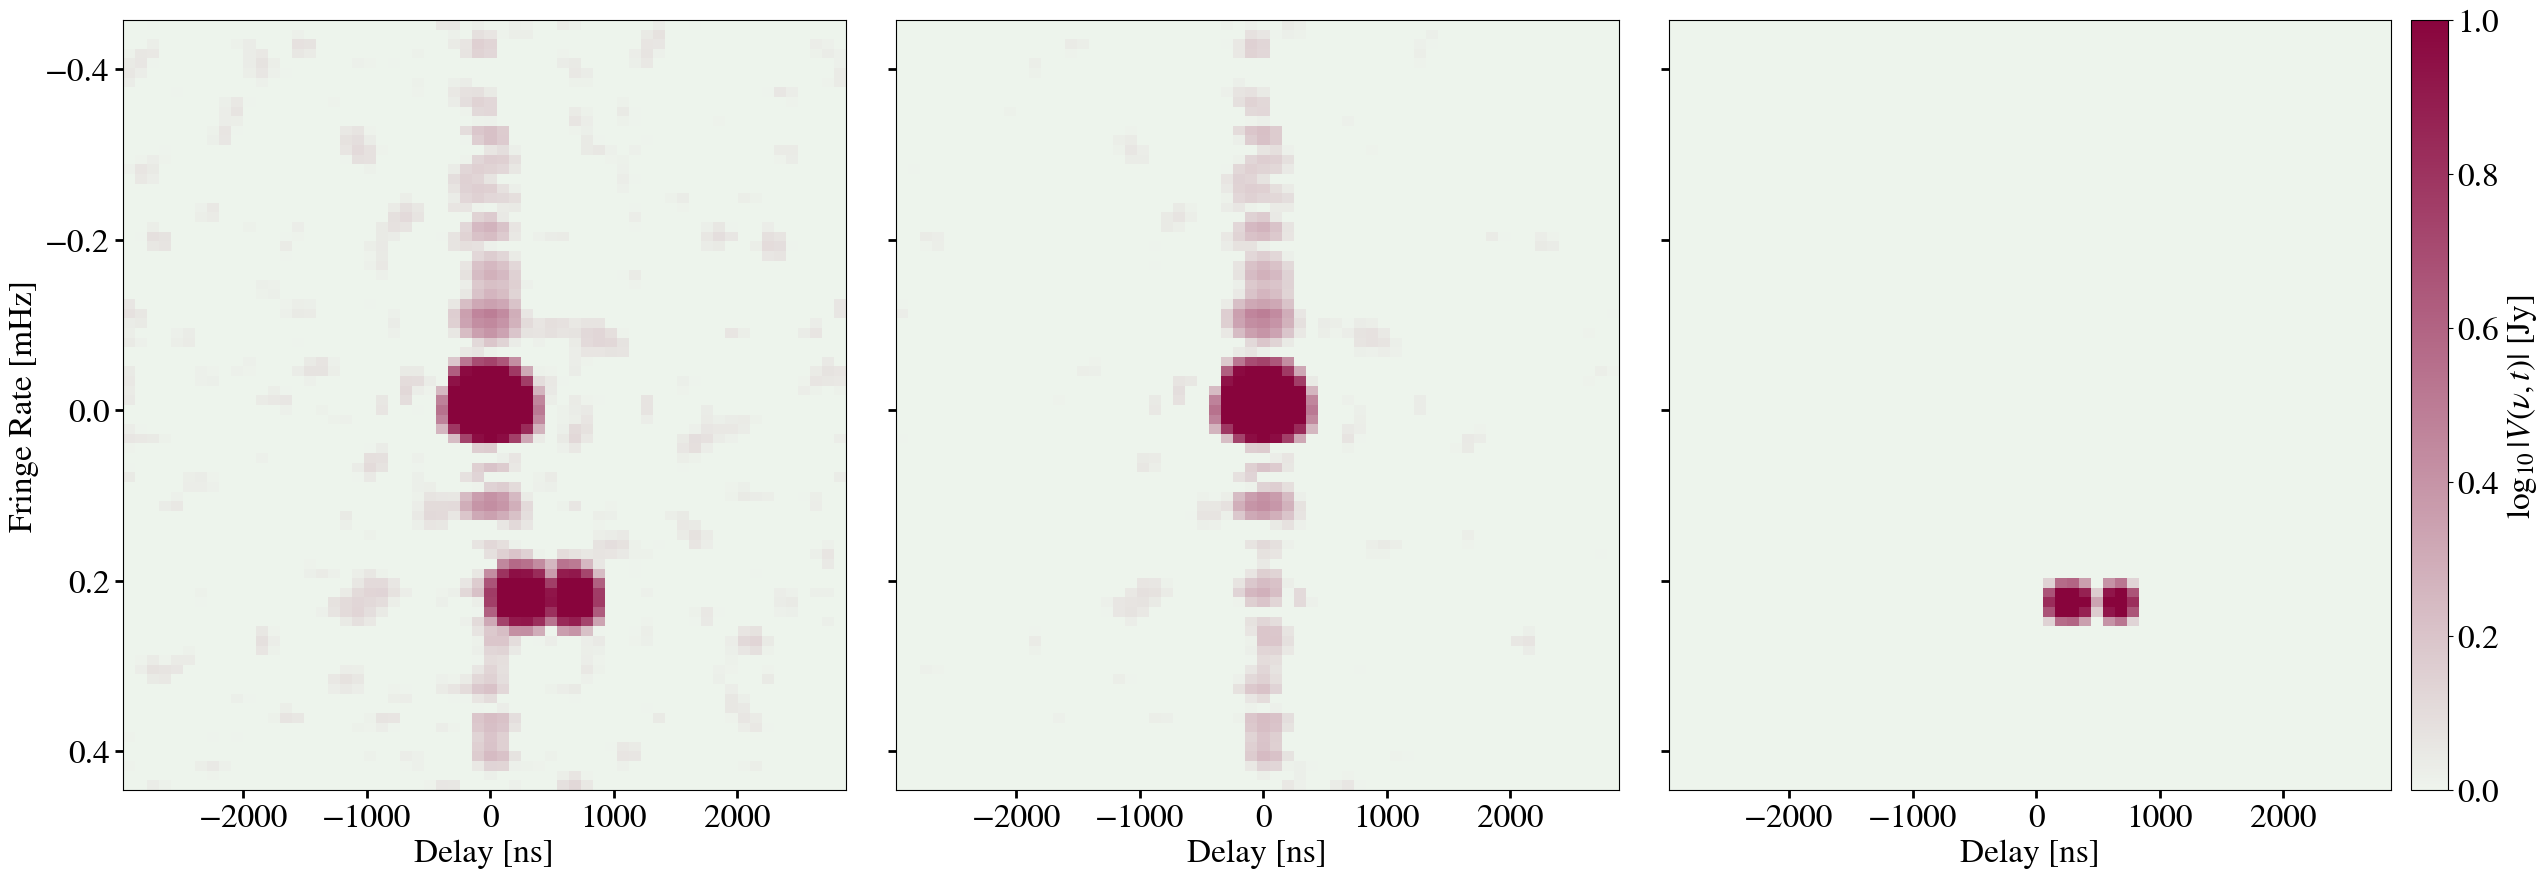

In [ ]:
# plt.rcParams.update({'font.size': 60})
# --- prep data (your existing calls) ---

fig = plt.figure(figsize=(30,10))
ax = ImageGrid(
    fig, 111,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="5%",
    cbar_pad=0.2,
    aspect=False
)

im0 = plot_waterfalls_from_dlfr(
    data_true_dlfr, freqs*1e6, lsts,
    fig=fig, ax=ax[0], mode='log',
    vmin=0, vmax=2.5, cmap=paper_map_pink, dynamic_range=dynamic_range,
    limit_drng='all', colorbar_flag=False, baseline=None, horizon_color='magenta'
)

im1 = plot_waterfalls_from_dlfr(
    mean_sky_dlfr, freqs*1e6, lsts,
    fig=fig, ax=ax[1], mode='log',
    vmin=0, vmax=2.5, cmap=paper_map_pink, dynamic_range=dynamic_range,
    limit_drng='all', colorbar_flag=False, baseline=None, horizon_color='magenta'
)

im2 = plot_waterfalls_from_dlfr(
    delta_g_dlfr_mean, freqs*1e6, lsts,
    fig=fig, ax=ax[2], mode='log',
    vmin=0, vmax=1, cmap=paper_map_pink, dynamic_range=dynamic_range,
    limit_drng='all', colorbar_flag=False, baseline=None, horizon_color='magenta'
)

vis_label = r"$\log_{10}|V(\nu, t)|$ [Jy]"
cbar = ax.cbar_axes[0].colorbar(im2, label=vis_label)

# plt.savefig(fig_dir+'/data_vs_sky.pdf',bbox_inches='tight',dpi=300)

## Figure 6: Errors Components

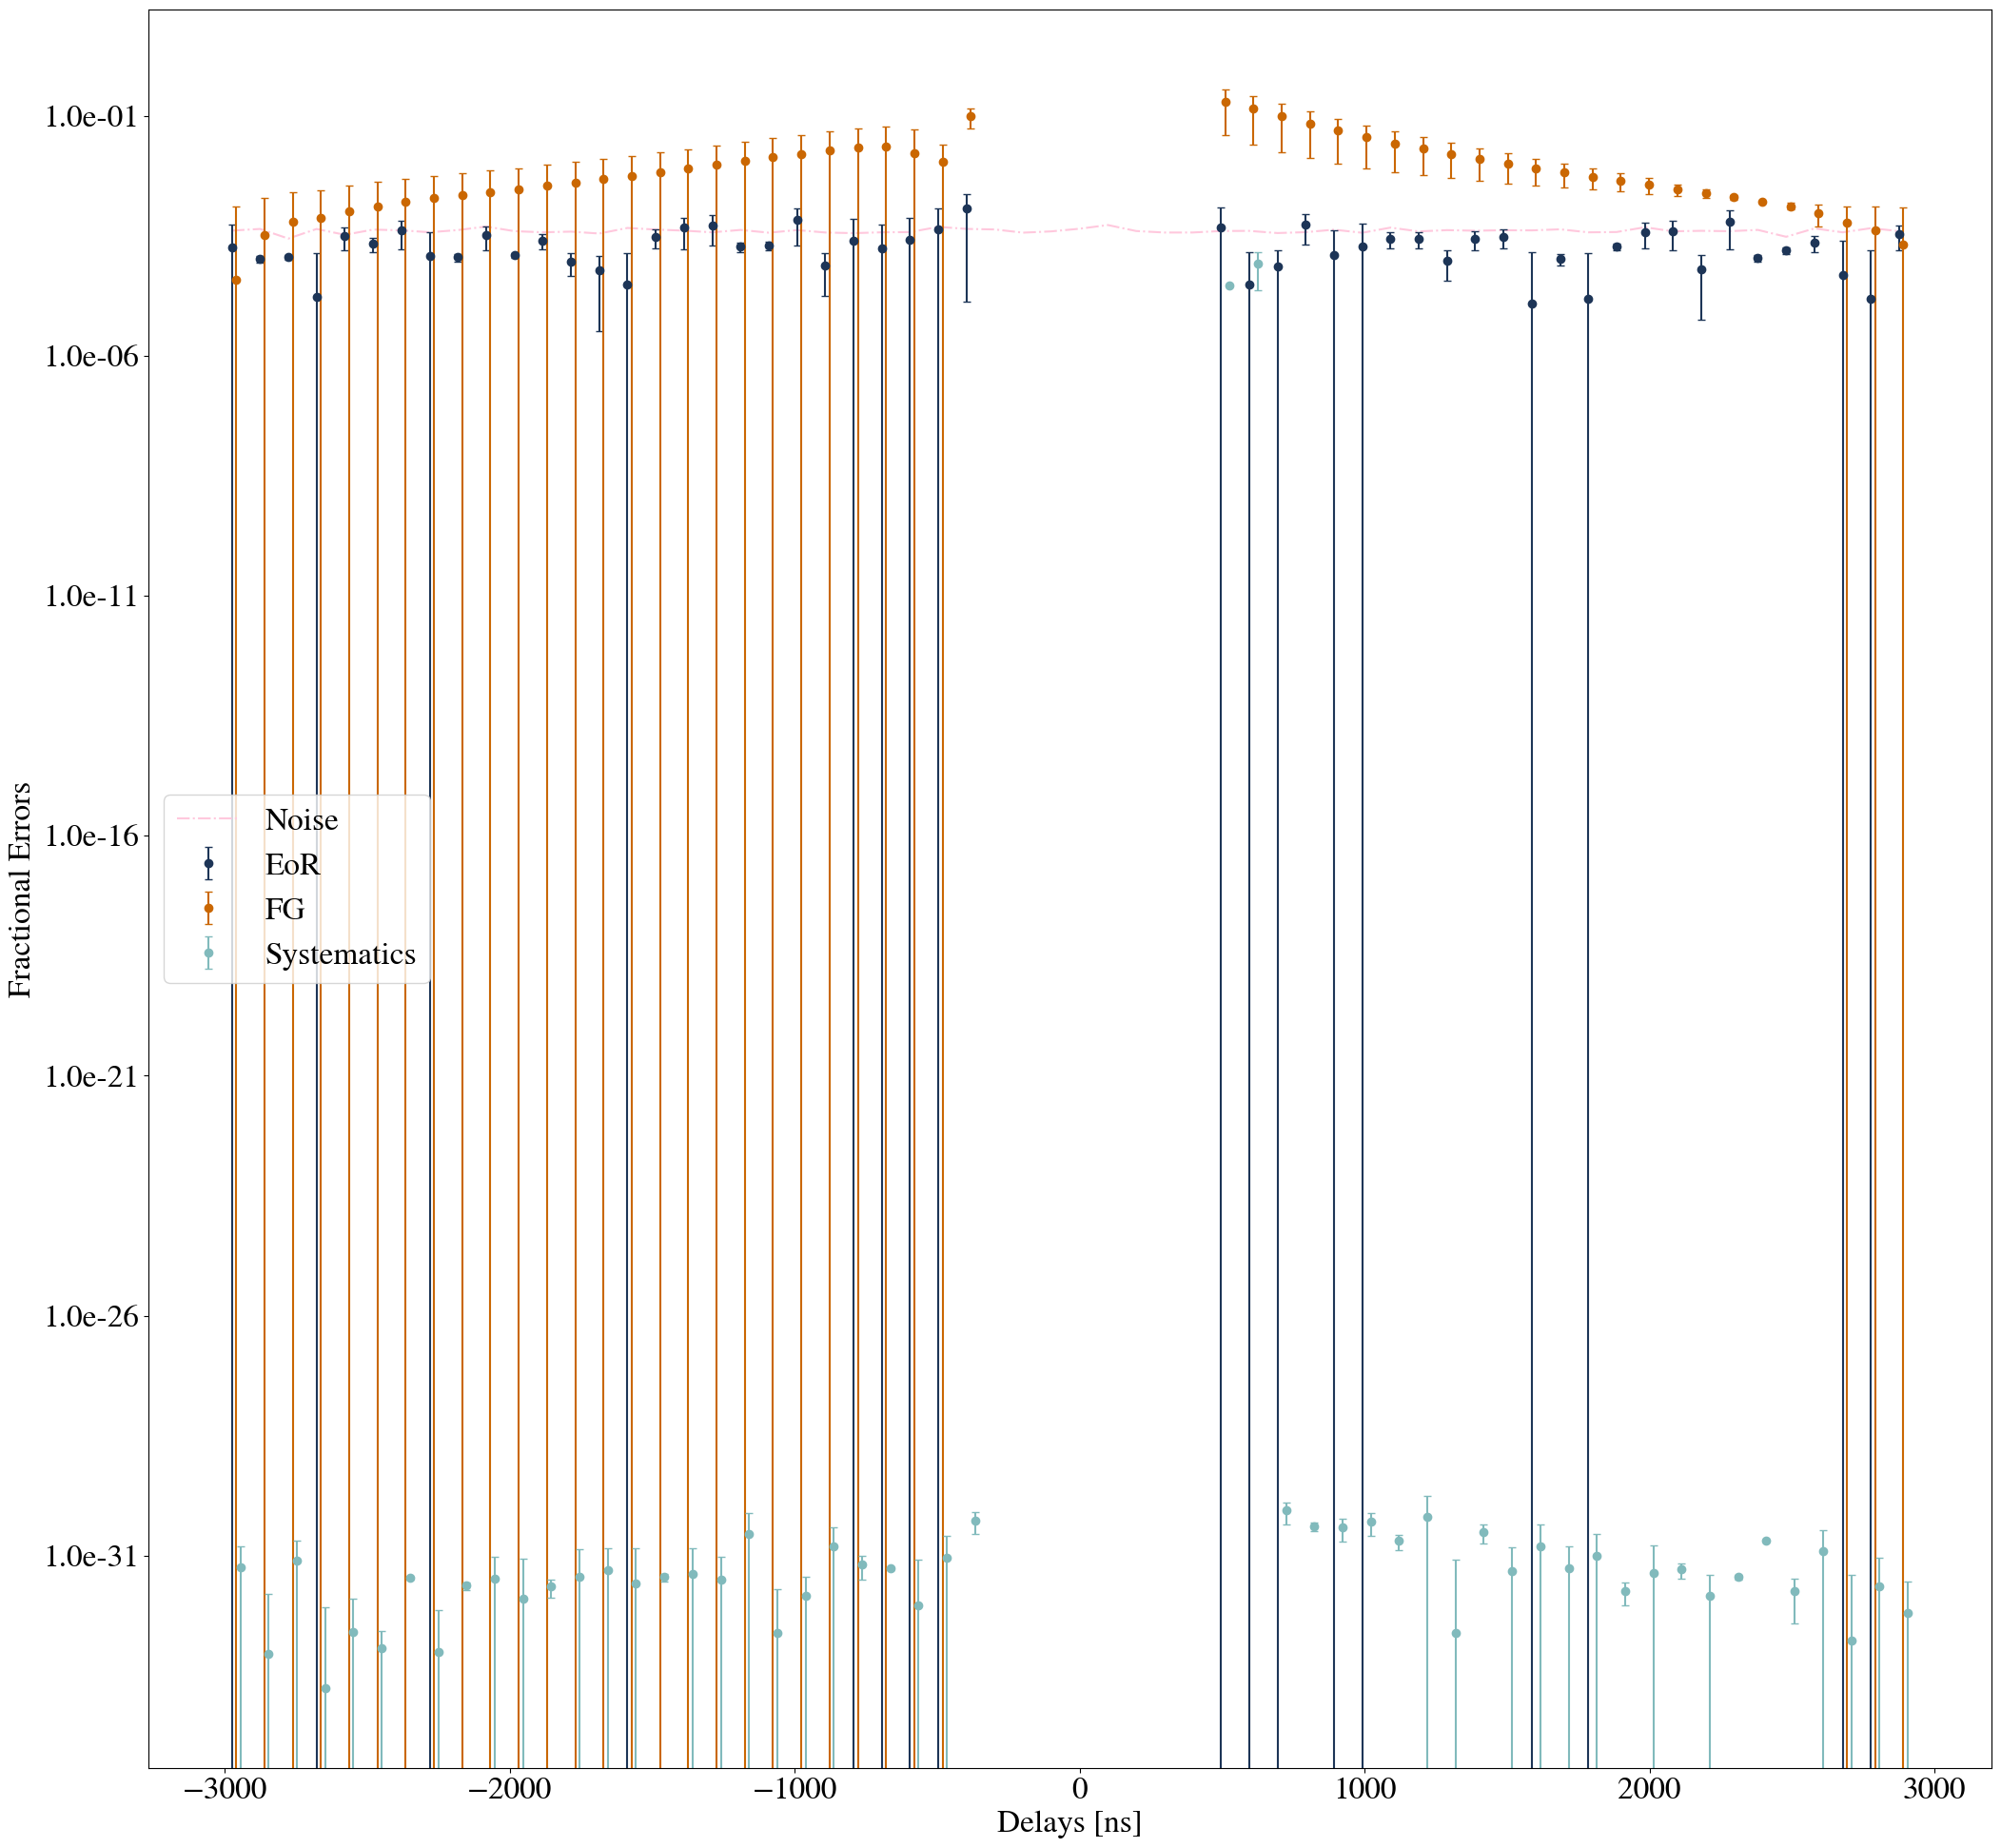

In [19]:
'''Plotting abs errors with log yscale'''
fig, axs = plt.subplots(1,1,figsize=(25,24))

data_arr = [eor_pspec_true-ps_sample,fg_pspec_true-ps_fg,sys_pspec_true-ps_sys]
plot_arr = [eor_pspec_true-eor_pspec_avg,fg_pspec_true-fg_pspec_avg,sys_pspec_true-sys_pspec_avg]
fig_labels=['EoR','FG','Systematics','Noise']

rm = np.arange(27,35)
keep = np.ones(len(plot_arr[0]),dtype=bool)
keep[rm]=False


axs.plot(delays,np.abs(n_pspec),ls='-.',c=colors[-1],label=fig_labels[-1])

for i in range(3):
    if i<2:
        plot_arr[i]=plot_arr[i][keep]
        data_arr[i]=data_arr[i][:,keep]
        std = np.std(np.abs(data_arr[i]),axis=0)
        errs=np.vstack((
            plot_arr[i] - std,
            std - plot_arr[i]
        ))
        axs.errorbar(
        delays[keep].value+(i*15),
        np.abs(plot_arr[i]),
        yerr=np.abs(errs),   # symmetric errors
        fmt='o',
        color=colors[i],
        label=fig_labels[i],
        capsize=3
        )
        axs.legend()
        mu  = np.abs(data_arr[i].mean(axis=0))          # (4,)
        sig = np.abs(data_arr[i].std(axis=0, ddof=1))   # (4,)  use ddof=1 for sample std
    else:
        plot_arr[i]=plot_arr[i][keep]
        data_arr[i]=data_arr[i][:,keep]
        std = np.std(np.abs(data_arr[i]),axis=0)
        errs=np.vstack((
            plot_arr[i] - std,
            std - plot_arr[i]
        ))
        axs.errorbar(
        delays[keep].value+(i*15),
        np.abs(plot_arr[i]),
        yerr=np.abs(errs),   # symmetric errors
        fmt='o',
        color=colors[i],
        label=fig_labels[i],
        capsize=3
        )
        axs.legend()
        mu  = np.abs(data_arr[i].mean(axis=0))          # (4,)
        sig = np.abs(data_arr[i].std(axis=0, ddof=1))   # (4,)  use ddof=1 for sample std


    # 3-sigma band + mean points
    # plt.fill_between(
    #     delays.value+(i*15), mu - sig, mu + sig,
    #     color=colors[i], alpha=0.20, linewidth=0, label=r"$\pm 3\sigma$"
    # )
    


# plt.ylim(-0.001,0.001)
axs.set_yscale('log')

axs.set_xlabel('Delays [ns]')
axs.set_ylabel('Fractional Errors')
axs.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))

# plt.savefig(fig_dir+'/errors_components.pdf',bbox_inches='tight',dpi=300)

TypeError: 'Axes' object is not subscriptable

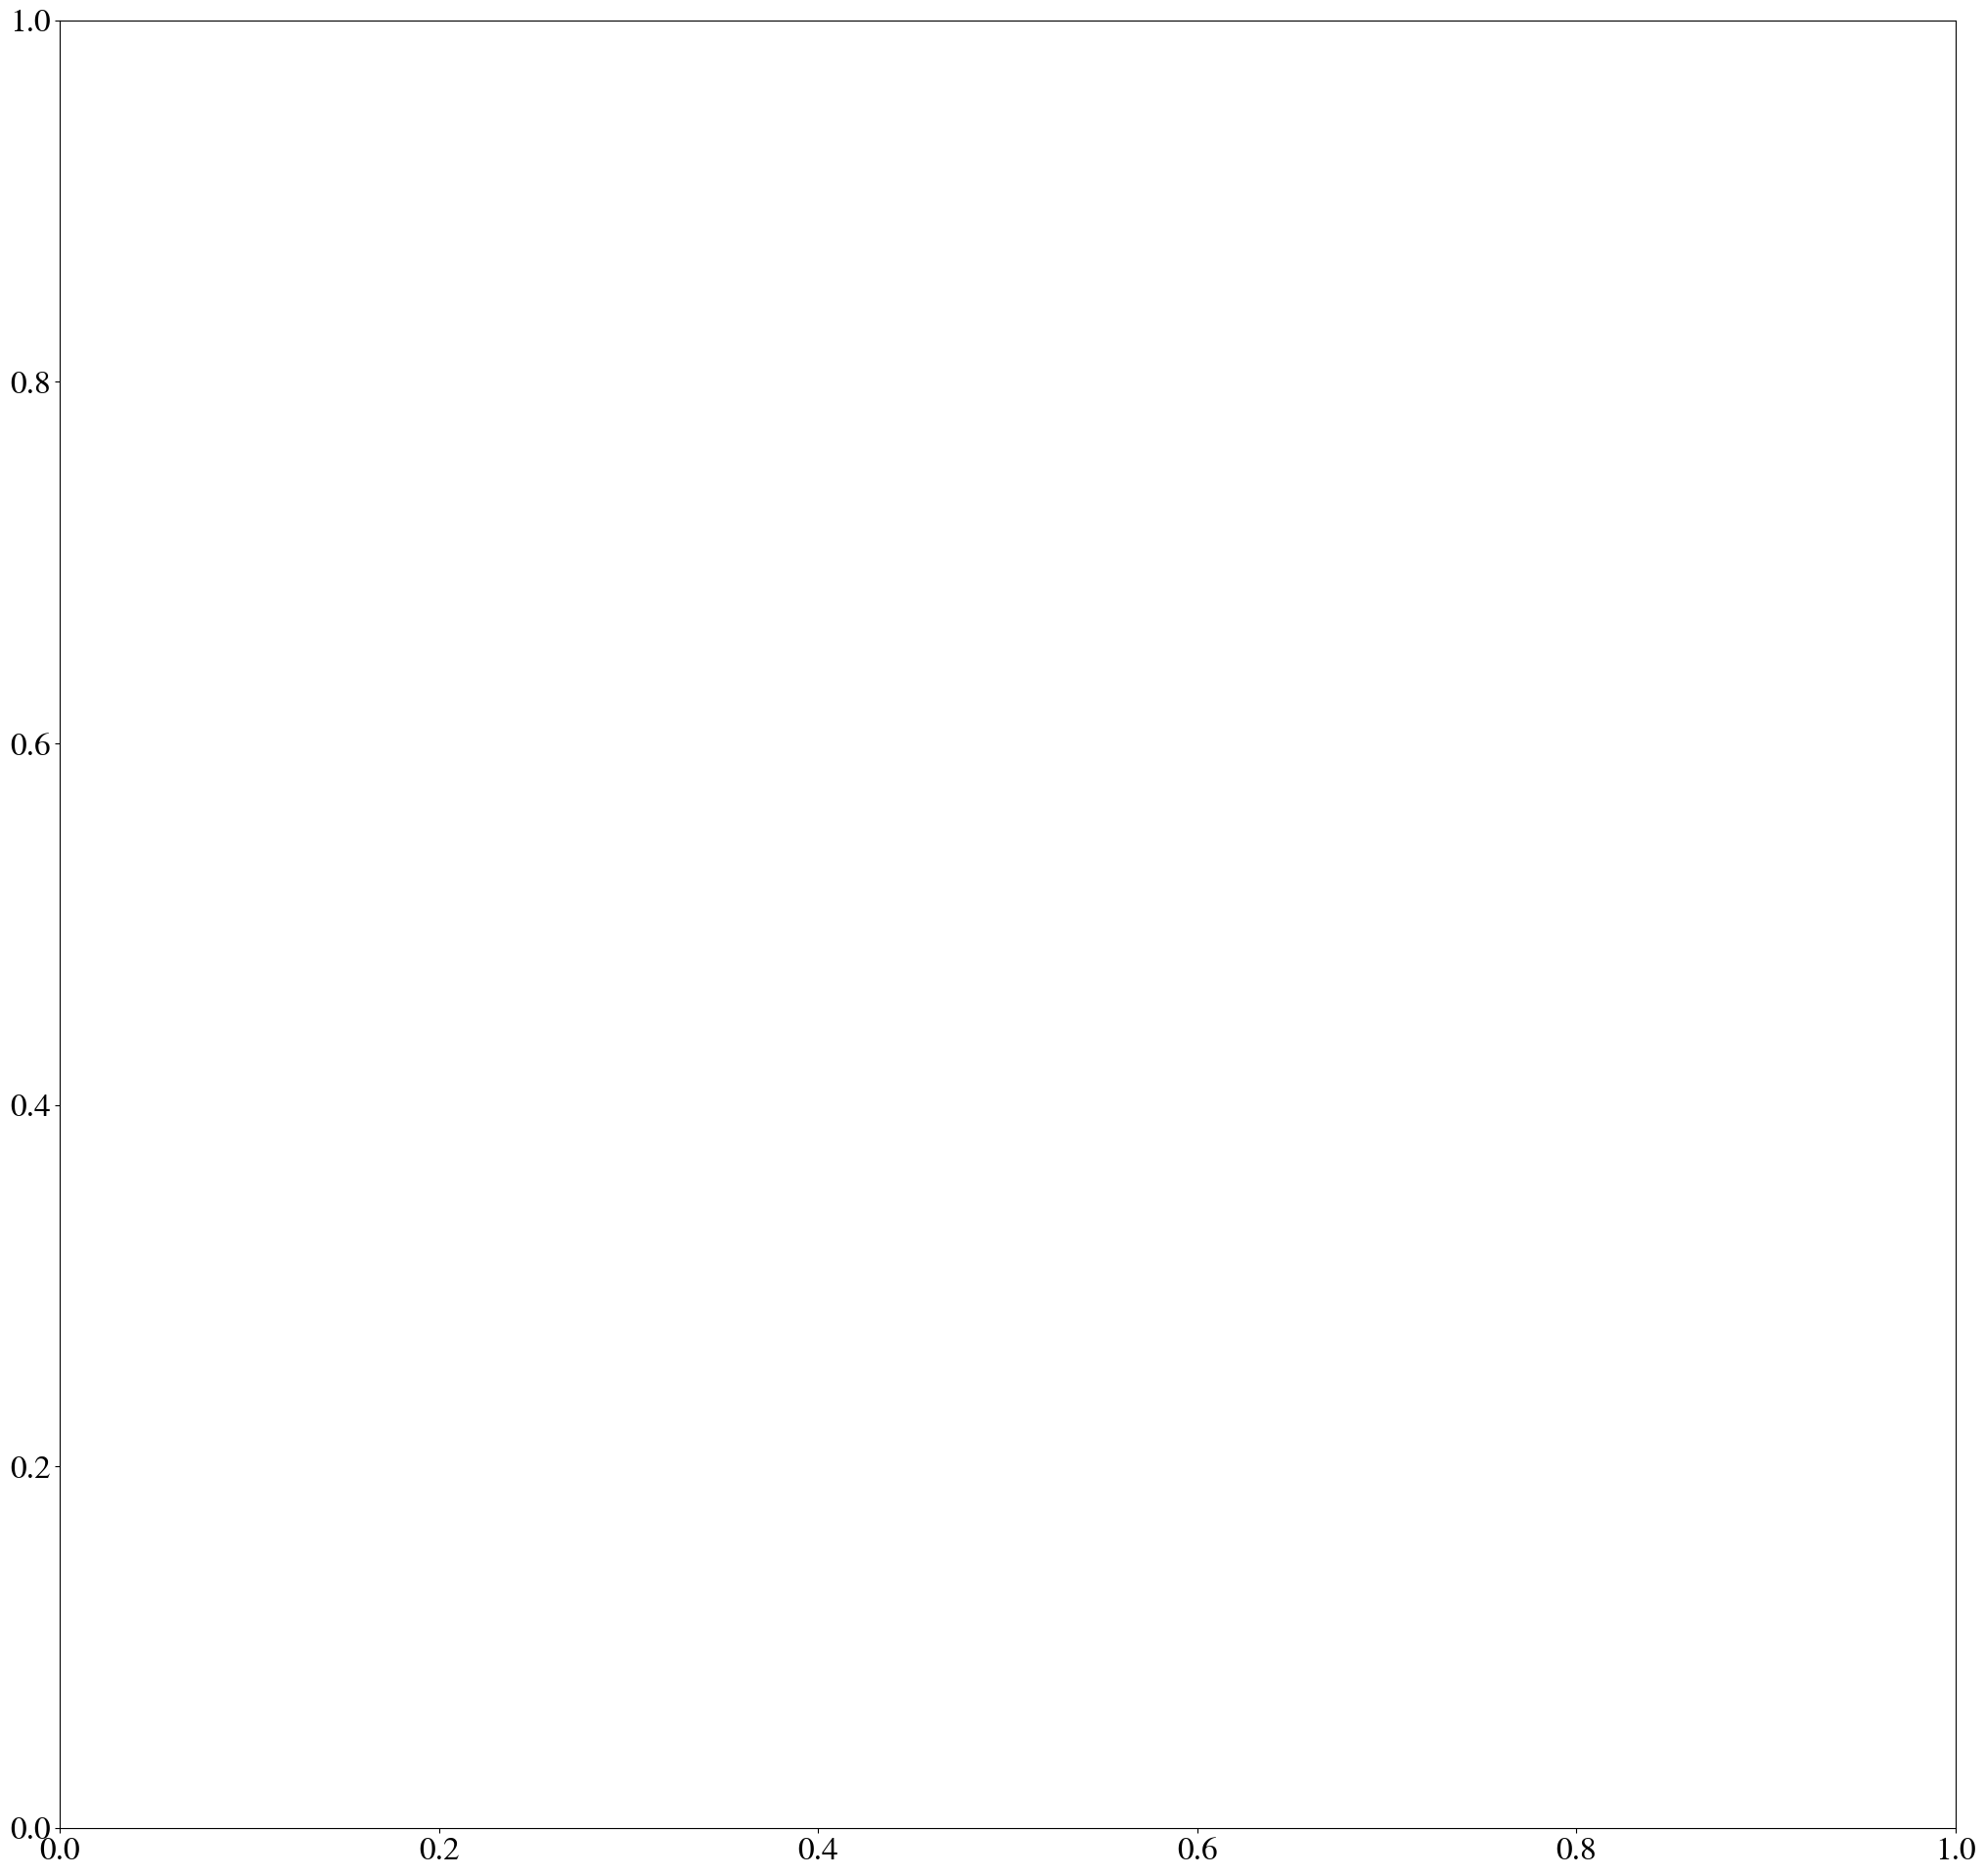

In [ ]:
'''Plotting in 3 subplots'''

fig, axs = plt.subplots(3,1,figsize=(25,24))

data_arr = [eor_pspec_true-ps_sample,fg_pspec_true-ps_fg,sys_pspec_true-ps_sys]
plot_arr = [eor_pspec_true-eor_pspec_avg,fg_pspec_true-fg_pspec_avg,sys_pspec_true-sys_pspec_avg]
fig_labels=['EoR','FG','Systematics','Noise']

rm = np.arange(27,35)
keep = np.ones(len(plot_arr[0]),dtype=bool)
keep[rm]=False

for ax in axs:
    ax.plot(delays,n_pspec,ls='-.',c=colors[-1],label=fig_labels[-1])

for i in range(3):
    if i<2:
        plot_arr[i]=plot_arr[i][keep]
        data_arr[i]=data_arr[i][:,keep]
        std = np.std(data_arr[i],axis=0)
        errs=np.vstack((
            plot_arr[i] - std,
            std - plot_arr[i]
        ))
        axs[i].errorbar(
        delays[keep].value+(i*15),
        plot_arr[i],
        yerr=np.abs(errs),   # symmetric errors
        fmt='o',
        color=colors[i],
        label=fig_labels[i],
        capsize=3
        )
        axs[i].legend()
        mu  = data_arr[i].mean(axis=0)          # (4,)
        sig = data_arr[i].std(axis=0, ddof=1)   # (4,)  use ddof=1 for sample std
    else:
        std = np.std(data_arr[i],axis=0)
        errs=np.vstack((
            plot_arr[i] - std,
            std - plot_arr[i]
        ))
        axs[i].errorbar(
        delays.value+(i*15),
        plot_arr[i],
        yerr=np.abs(errs),   # symmetric errors
        fmt='o',
        color=colors[i],
        label=fig_labels[i],
        capsize=3
        )
        axs[i].legend()
        mu  = data_arr[i].mean(axis=0)          # (4,)
        sig = data_arr[i].std(axis=0, ddof=1)   # (4,)  use ddof=1 for sample std


    # 3-sigma band + mean points
    # plt.fill_between(
    #     delays.value+(i*15), mu - sig, mu + sig,
    #     color=colors[i], alpha=0.20, linewidth=0, label=r"$\pm 3\sigma$"
    # )
    


# plt.ylim(-0.001,0.001)
# plt.yscale('log')
for ax in axs:
    ax.set_xlabel('Delays [ns]')
    ax.set_ylabel('Fractional Errors')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))

# plt.savefig(fig_dir+'/errors_components.pdf',bbox_inches='tight',dpi=300)

## Figure 8: Systematics fractional error

ValueError: 'yerr' must not contain negative values

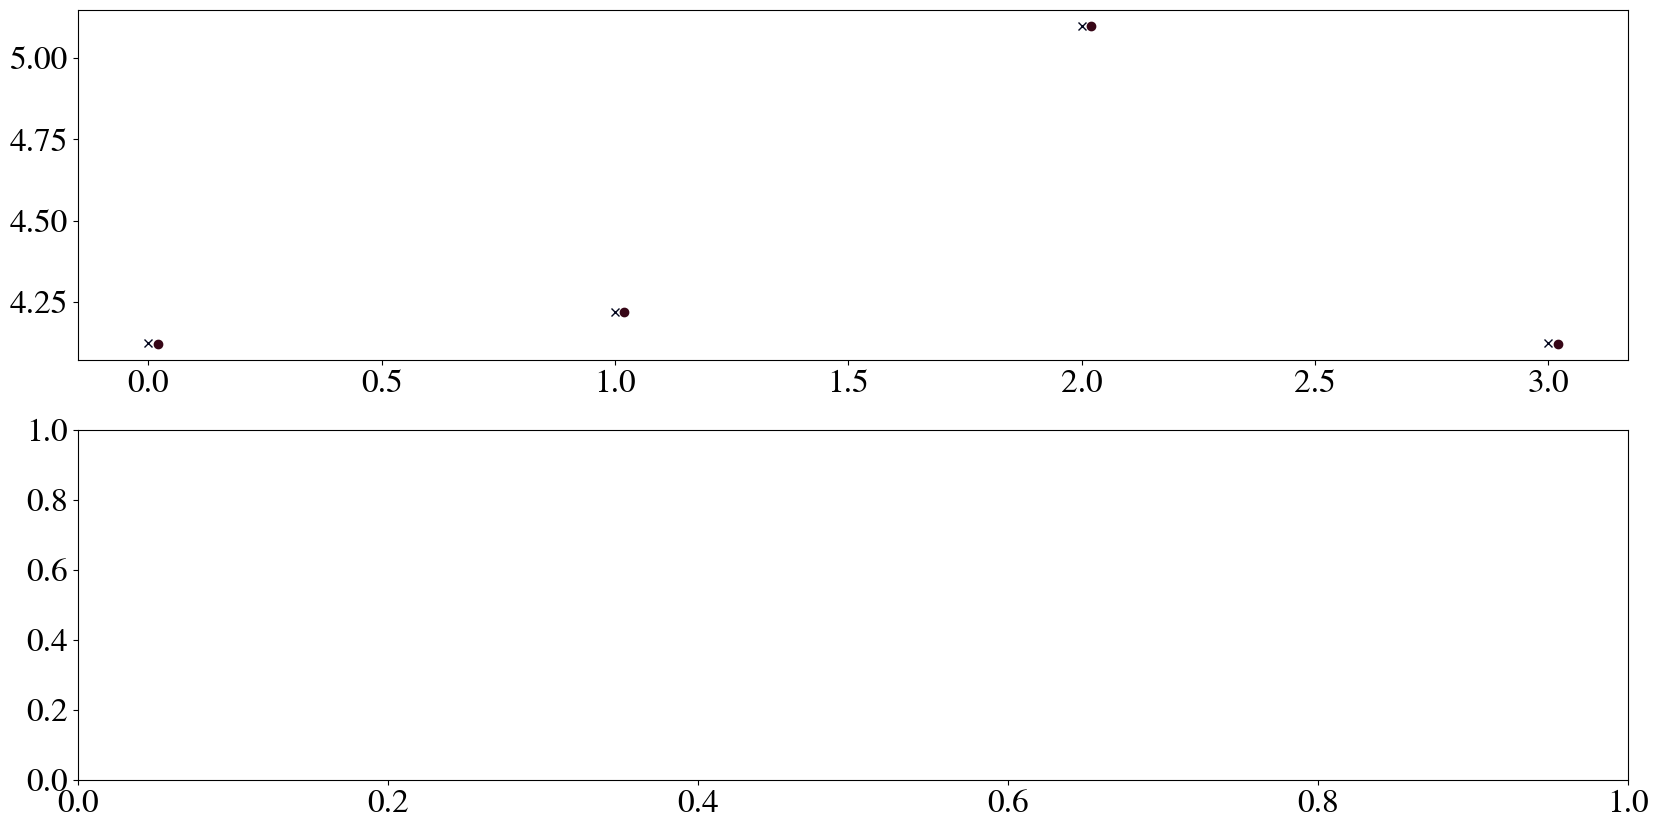

In [32]:
fig,ax=plt.subplots(2,1,figsize=(20,10))

errs=np.vstack((
        np.abs(np.std(b_sys_gcr,axis=0)),
        -1. * np.abs(np.std(b_sys_gcr,axis=0))
        # np.std(b_sys_gcr,axis=0) - b_sys_gcr.mean(axis=0)
    ))

ax[0].plot(np.abs(sys_amps_true),'x',c=colors[0],label='True')
ax[0].errorbar([0.02,1.02,2.02,3.02],
    np.abs(b_sys_gcr.mean(axis=0)),
    fmt='o',
    yerr=errs,
    label='Sample Mean',
    capsize=3,
    c=colors[1])
ax[0].set_ylabel("Amplitude (arbitrary units)")
ax[0].set_xticks([0,1,2,3],labels=[r"$b_{sys,1}$", r"$b_{sys,2}$", r"$b_{sys,3}$", r"$b_{sys,4}$"])

res_mean=np.abs(sys_amps_true-b_sys_gcr.mean(axis=0))/np.abs(sys_amps_true)
res=np.abs(sys_amps_true-b_sys_gcr)/np.abs(sys_amps_true)

ax[0].legend()

ax[1].plot([0,1,2,3],
               res_mean,
               'o',
               label='Fractional Errors')
ax[1].plot([0,1,2,3],np.abs(np.std(b_sys_gcr,axis=0)),'x')
ax[1].set_xticks([0,1,2,3],labels=[r"$b_{sys,1}$", r"$b_{sys,2}$", r"$b_{sys,3}$", r"$b_{sys,4}$"])
ax[1].axhline(0,c='k',ls='dotted')
ax[1].set_ylabel("Fractional errors")
ax[1].set_ylim(-0.002,0.002)
ax[1].legend()
# plt.savefig(fig_dir+'/sys_frac_error.pdf',bbox_inches='tight',dpi=300)

# Data Plots

## Figure 2: Plotting the different systematic locations in DL FR space

3 0
4 0
5 0
6 0
10 0
11 0
12 0
13 0
3 20
4 20
5 20
6 20


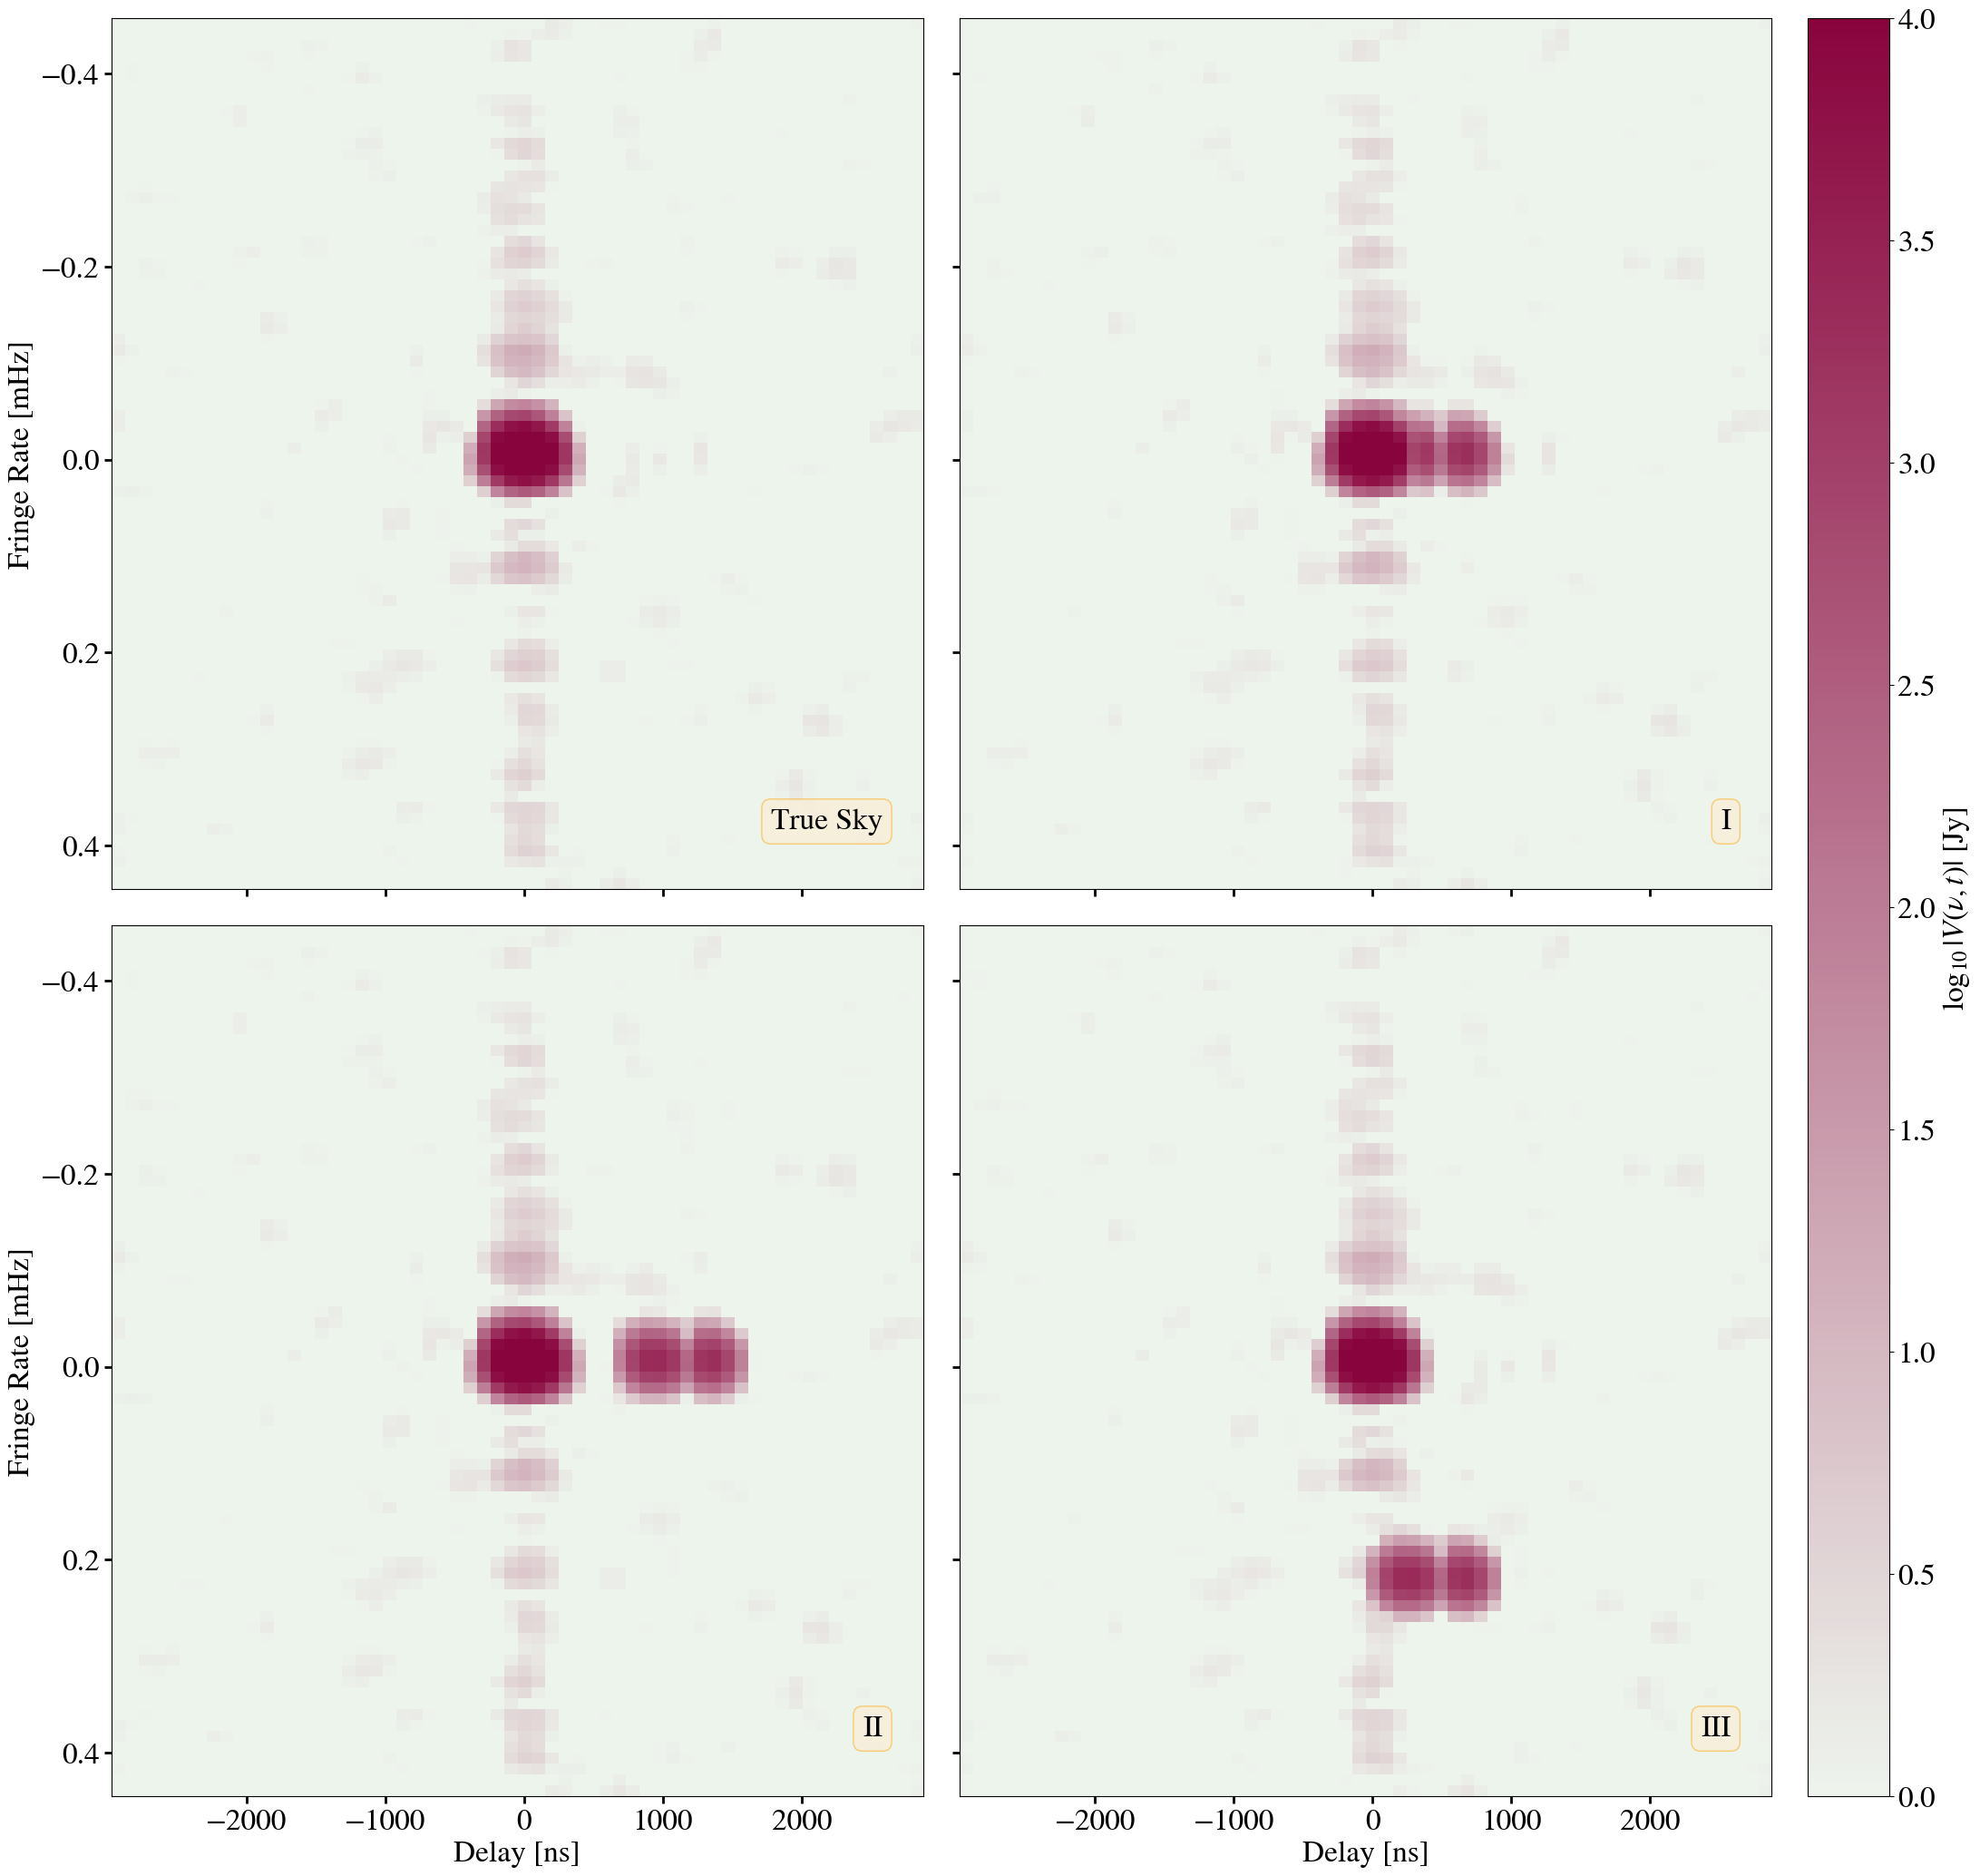

In [ ]:
# fig,axs = plt.subplots(2,2,layout="constrained",figsize=(20,20))
fig = plt.figure(figsize=(20.,20.))
axs = ImageGrid(
    fig,
    rect=(0.06, 0.06, 0.98, 0.98),   # leave room for labels + shared cbar
    nrows_ncols=(2, 2),
    axes_pad=0.4,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.4,
    label_mode="L",
    aspect=False,
)
result_dir='paper_plots/'
run_version_arr = ['low_dl_fr_0','high_dl_fr_0','low_dl_fr_20']

nm_list_arr = [
            [(3,0),(4,0),(5,0),(6,0)],
            [(10,0), (11,0), (12,0), (13,0)],
            [(3,20),(4,20),(5,20),(6,20)]
            ]

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
i=0

eor_true=np.load(result_dir+run_version_arr[0]+'/eor_true.npy')[:Ntimes,:Nfreqs]
fg_true=np.load('npy_data/fg_true.npy')[:Ntimes,:Nfreqs]
ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
data_true = eor_true+ fg_true

data_true_dlfr = data_dly_fr(data_true,freqs*1e6, lsts, windows='blackman-harris')

_=plot_waterfalls_from_dlfr(data_true_dlfr, freqs*1e6, lsts, fig=fig,ax=axs[0], mode='log', 
                vmin=0,vmax=4,cmap=paper_map_pink, dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',colorbar_flag=False)
axs[0].text(0.95,0.07,'True Sky',bbox=bbox,
            transform=axs[0].transAxes, horizontalalignment='right')

fig_labels = ['I','II','III']
for run_version in run_version_arr:
    sys_modes_operator = sys_modes(freqs_Hz=freqs*1e6, 
                                    times_sec=lsts * 24./(2.*np.pi) * 3600., 
                                    modes=nm_list_arr[i])
    sys_model_true= (1+sys_modes_operator @ sys_amps_true).reshape((Nfreqs, Ntimes)).T
    total_data_true = sys_model_true * data_true
    total_data_dlfr = data_dly_fr(total_data_true,freqs*1e6, lsts, windows='blackman-harris')
    plot_op=plot_waterfalls_from_dlfr(total_data_dlfr, freqs*1e6, lsts, fig=fig,ax=axs[i+1], mode='log', 
                vmin=0,vmax=4,cmap=paper_map_pink, dynamic_range=5, limit_drng='all', colorbar_flag=False,
                baseline=None, horizon_color='magenta')
    axs[i+1].text(0.95,0.07,fig_labels[i],bbox=bbox,
            transform=axs[i+1].transAxes, horizontalalignment='right')
    i=i+1
vis_label= r"$\log_{10}|V(\nu, t)|$ [Jy]"
axs.cbar_axes[0].colorbar(plot_op, label=vis_label)
# plt.savefig(fig_dir+'/'+'test_cases_in_dlfr.pdf',bbox_inches='tight',dpi=300)

## Data Components

In [9]:
'''Loading Data from uvh5'''
uvd=UVData()
uvd.read('/nvme2/scratch/sohini/hydra-pspec-systematic/test_data/vis-eor.uvh5')
uvd=form_pseudo_stokes_vis(uvd)
antpairpols=uvd.get_antpairpols()
vis_eor=uvd.get_data(antpairpols[0], force_copy=True) #EoR test
freqs_=uvd.freq_array
freqs_eor=freqs_.reshape(freqs_.shape[0],) #[0]
lst_eor=np.unique(uvd.lst_array)

uvd=UVData()
uvd.read('/nvme2/scratch/sohini/hydra-pspec-systematic/test_data/vis-ptsrc-gsm.uvh5')
uvd=form_pseudo_stokes_vis(uvd)
antpairpols=uvd.get_antpairpols()
fg_true=uvd.get_data(antpairpols[0], force_copy=True) #EoR test
freqs_fg=freqs_.reshape(freqs_.shape[0],) #[0]
lst_fg=np.unique(uvd.lst_array)

uvd=UVData()
uvd.read('/nvme2/scratch/sohini/hydra-pspec-systematic/hera_val/vis_corrupted_test.uvh5')
uvd=form_pseudo_stokes_vis(uvd)
antpairpols=uvd.get_antpairpols()
vis_corr=uvd.get_data(antpairpols[0], force_copy=True) #EoR test
freqs_corr=freqs_.reshape(freqs_.shape[0],) #[0]
lst_corr=np.unique(uvd.lst_array)

uvd=UVData()
uvd.read('/nvme2/scratch/sohini/hydra-pspec-systematic/test_data/vis-eor-ptsrc-gsm.uvh5')
uvd=form_pseudo_stokes_vis(uvd)
antpairpols=uvd.get_antpairpols()
vis_sky=uvd.get_data(antpairpols[0], force_copy=True) #EoR test
freqs_sky=freqs_.reshape(freqs_.shape[0],) #[0]
lst_sky=np.unique(uvd.lst_array)

noise=np.load('/nvme2/scratch/sohini/hydra-pspec-systematic/test_data/noise.npy')

## Figure 1: Data in DL-FR space

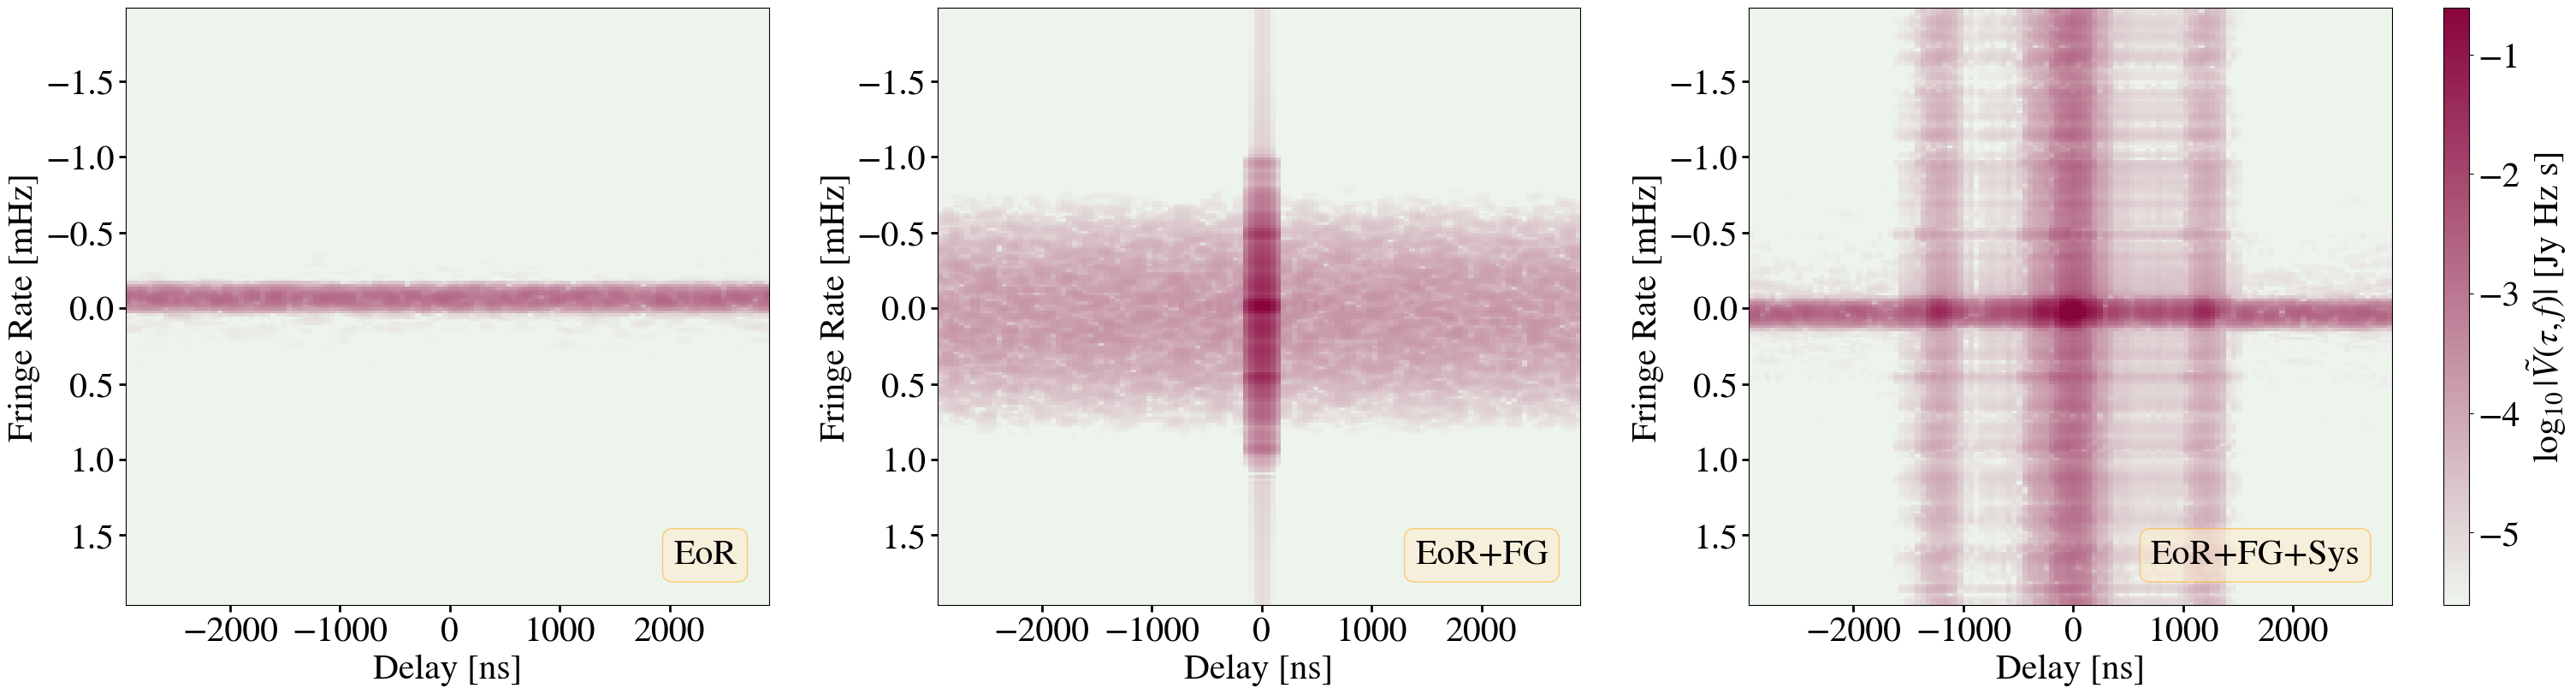

In [10]:
fig = plt.figure(figsize=(30, 8), constrained_layout=True)
gs  = fig.add_gridspec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 0.04], wspace=0.08)
plt.rcParams.update({'font.size': 30})

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharex=ax0, sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2], sharex=ax0, sharey=ax0)
cax = fig.add_subplot(gs[0, 3])  # colorbar axis

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
vmax = np.log10(np.abs(vis_eor)).max()
vmin = vmax - dynamic_range

norm = Normalize(vmin=vmin, vmax=vmax)
cmap = paper_map_pink

eor_dlfr=plot_waterfalls(vis_eor, freqs_eor, lst_eor, windows='blackman-harris', fig=fig,ax=ax0, mode='log', 
                vmin=-3,vmax=5,cmap=paper_map_pink, dynamic_range=5, limit_drng='all',colorbar_flag=False,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
ax0.text(0.95,0.07,'EoR',bbox=bbox,
            transform=ax0.transAxes, horizontalalignment='right')

fg_dlfr = plot_waterfalls(vis_sky, freqs_sky, lst_sky, windows='blackman-harris', mode='log', fig=fig,ax=ax1,
                vmin=-3,vmax=5,cmap=paper_map_pink, dynamic_range=5, limit_drng='all',colorbar_flag=False,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
ax1.text(0.95,0.07,'EoR+FG',bbox=bbox,
            transform=ax1.transAxes, horizontalalignment='right')

corr_dlfr=plot_waterfalls(vis_corr, freqs_corr, lst_corr, windows='blackman-harris', mode='log', fig=fig,ax=ax2,
                vmin=-3,vmax=5,cmap=paper_map_pink, dynamic_range=5, limit_drng='all',colorbar_flag=False,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)

ax2.text(0.95,0.07,'EoR+FG+Sys',bbox=bbox,
            transform=ax2.transAxes, horizontalalignment='right')

sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]")     

# plt.savefig(fig_dir+'/'+'data_in_dlfr_space.pdf',bbox_inches='tight',dpi=300)

## Systematics in visibility space

In [12]:
uvd=UVData()
uvd.read('test_data/vis-eor-fgs.uvh5')
antpairpols=uvd.get_antpairpols()
clean_vis=uvd.get_data(['xx'], force_copy=True) #EoR test
freqs=uvd.freq_array
freqs=freqs.reshape(freqs.shape,) #[0]
lsts=uvd.lst_array

uvd=UVData()
uvd.read('hera_val/vis_corrupted_test.uvh5')
antpairpols=uvd.get_antpairpols()
vis_corr=uvd.get_data(['xx'], force_copy=True) #EoR test
freqs=uvd.freq_array
freqs=freqs.reshape(freqs.shape,) #[0]
lsts=uvd.lst_array

In [27]:
freqs_mhz = freqs * u.MHz
times = Quantity(lsts * 12 / np.pi, unit='h')

xticklocs=[1,20,40,60,80,100,119]
yticklocs=[0,20,40,60,80,100,120,140,160,180,200]

xstep_freqs = (freqs[-1]-freqs[0])/freqs.size
ystep_times = (lsts[-1]-lsts[0])/lsts.size

xticks_freqs= freqs_mhz[xticklocs]
yticks_times = times[yticklocs]

xticklabels_freqs = [str(int(val*10e-7)) for val in xticks_freqs.value]
yticklabels_times = [str(round(val,2)) for val in yticks_times.value]

formatter_freqs = ticker.ScalarFormatter(useMathText=True)
formatter_freqs.set_powerlimits((6, 6))  # Force sci notation for values >= 1e6


## Figure 10: systematics in vis space

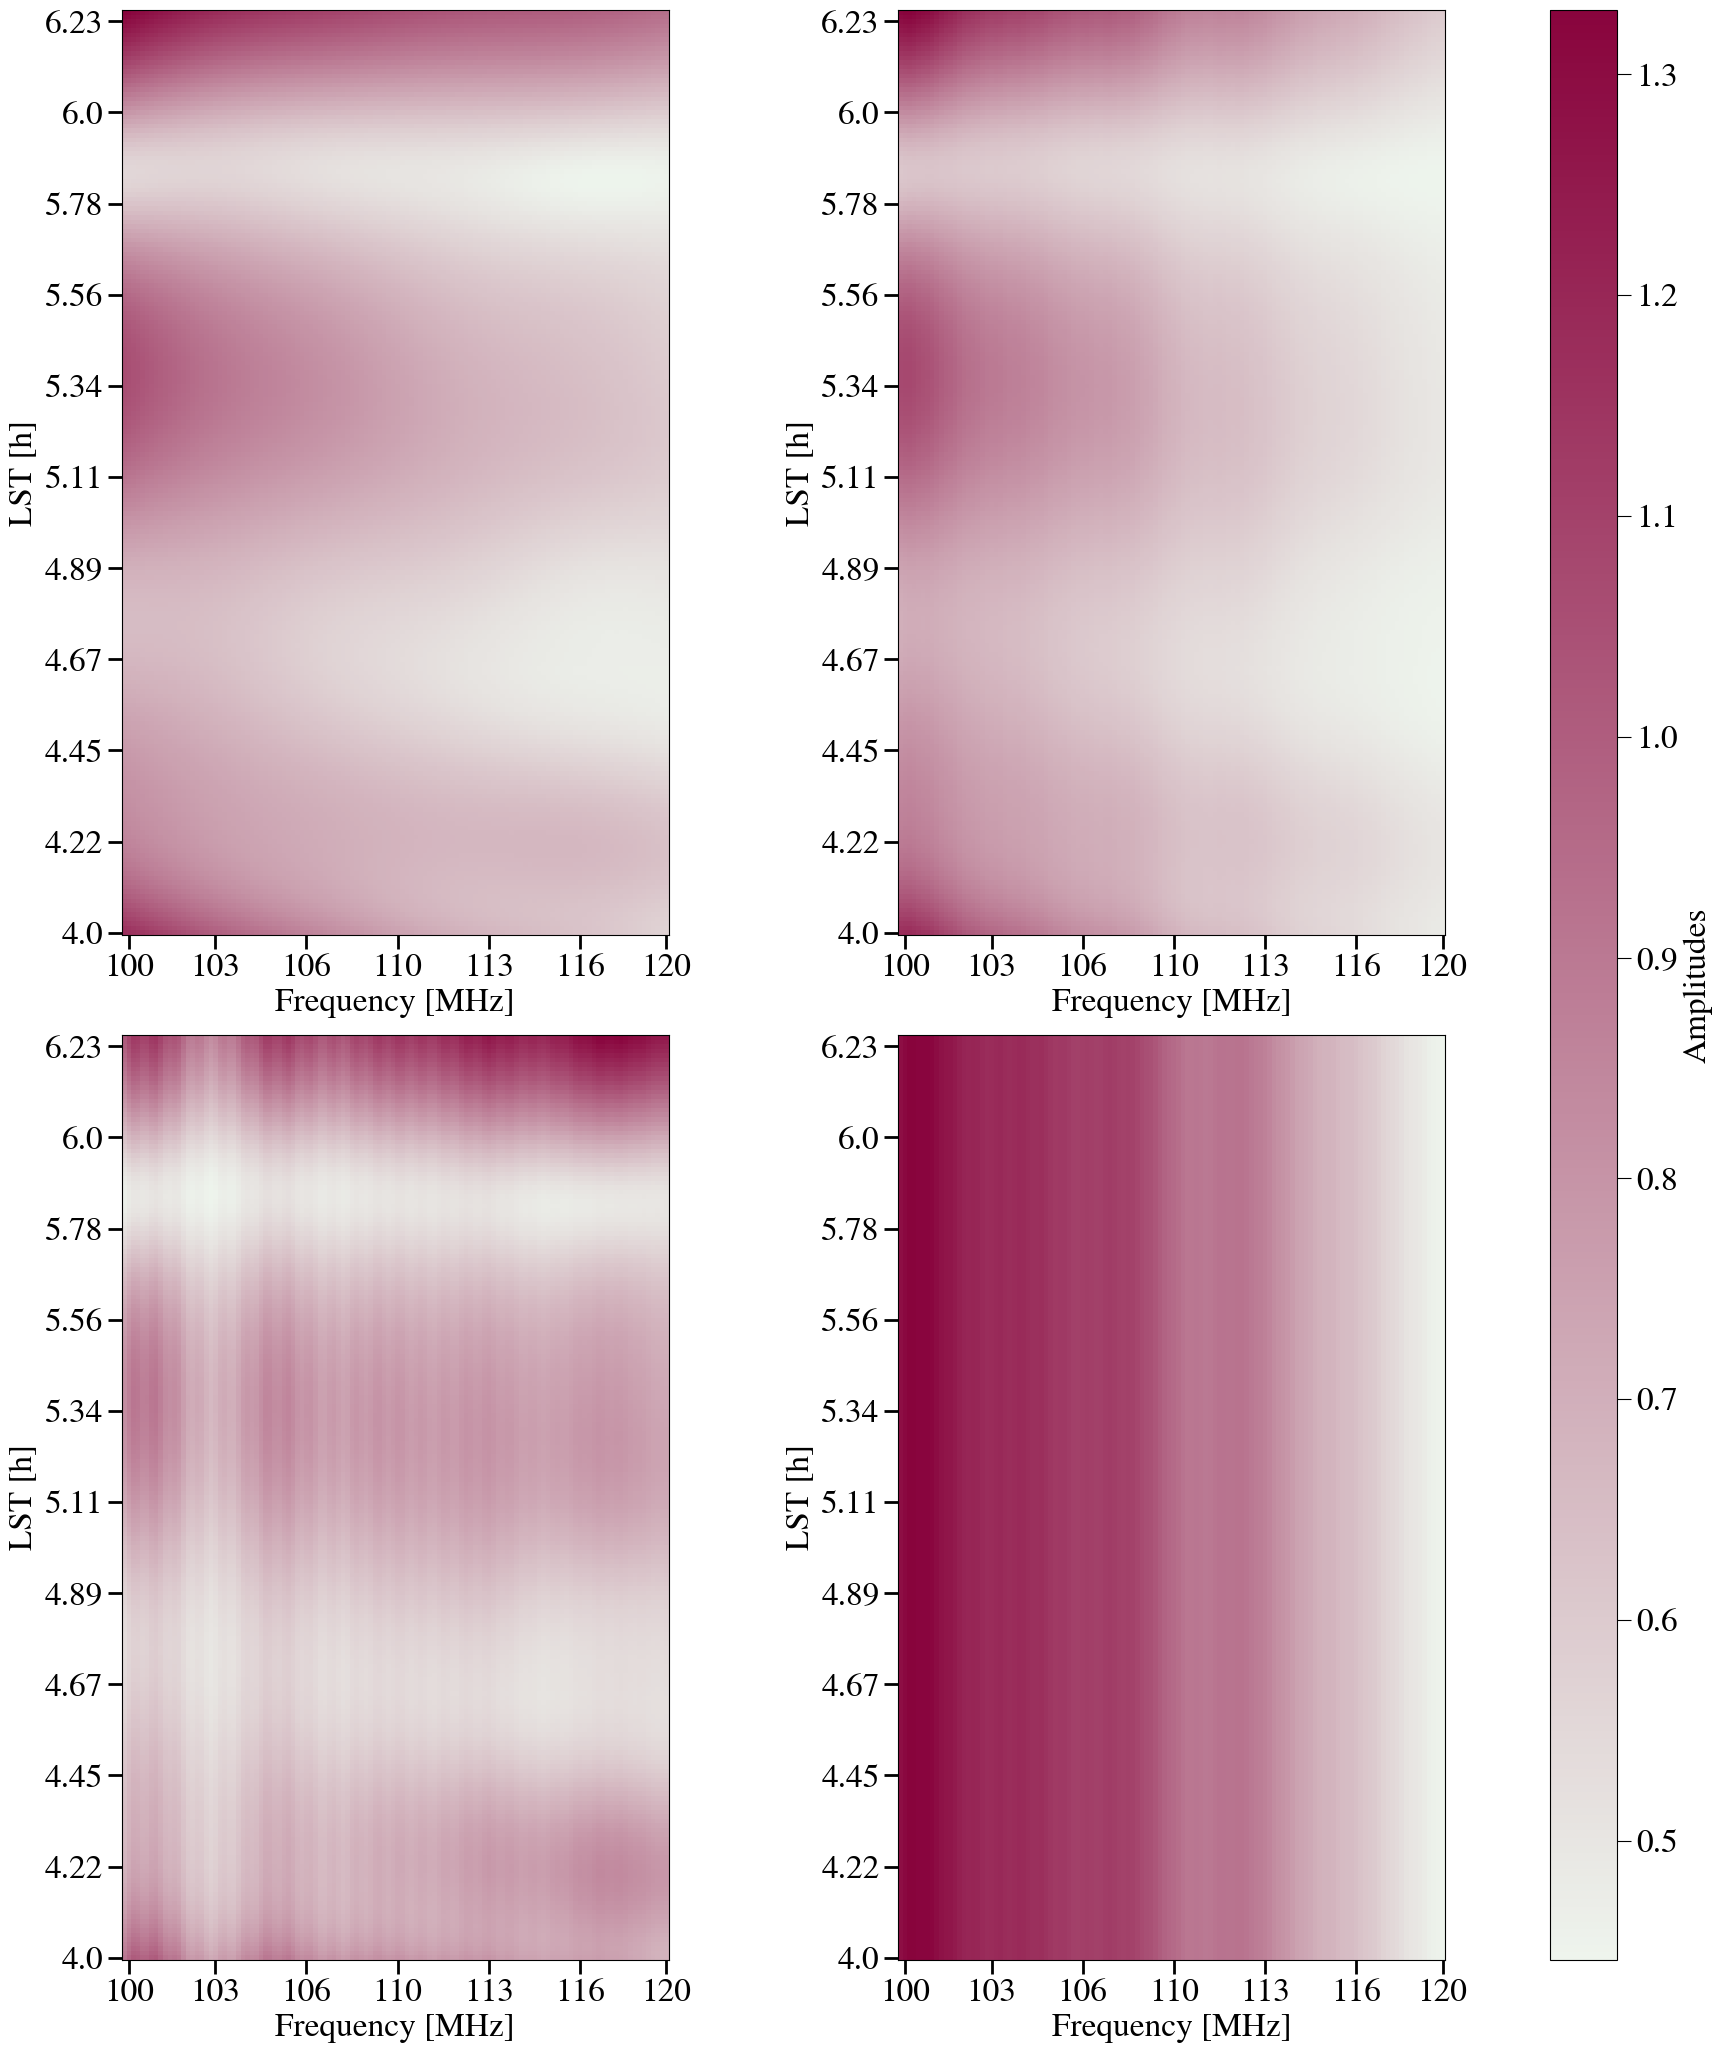

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(28,22))
fig = plt.figure(figsize=(20.,30.))
axs = ImageGrid(
    fig,
    rect=(0.06, 0.06, 0.78, 0.65),   # leave room for labels + shared cbar
    nrows_ncols=(2, 2),
    axes_pad=1,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.4,
    label_mode="all",
    aspect=False,
)
data_arr=np.array([[clean_vis,vis_corr],[vis_corr-clean_vis,vis_corr/clean_vis]])
title_list=[['Simulated sky visibilities','Simulated visbilities with systematics'],['Systematics as additive component','Systematics as gain component']]
a=0
for i in range(2):
    for j in range(2):
        im=axs[a].imshow(np.abs(data_arr[i,j,:,:]),cmap=paper_map_pink,origin='lower')
        # ax[i,j].set_title(title_list[i][j],pad=15)
        axs[a].set_xlabel('Frequency [MHz]')
        axs[a].set_ylabel('LST [h]')
        axs[a].tick_params(direction='out', length=6, width=2, colors='black',size=10)
        a=a+1

cbar=axs.cbar_axes[0].colorbar(im,label='Amplitudes')
cbar.ax.tick_params(which='both', color='black', labelcolor='black',size=10)


for a in axs:
    a.set_xticks(xticklocs,labels=xticklabels_freqs)
    a.set_yticks(yticklocs,labels=yticklabels_times)
# plt.savefig(fig_dir+'/'+'systematics_in_vis_space.pdf',bbox_inches='tight',dpi=300)

# Autocorrelation Studies

In [26]:
result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/'

for run_version in run_version_arr:
    print("Case: "+run_version)
    b_sys = np.load(result_dir+run_version+'/b-sys.npy')
    taus = emcee.autocorr.integrated_time(b_sys, c=5, tol=50, quiet=True, has_walkers=False)
    ess = 10000/taus
    print("\n Taus: {}\nEss:{}\n".format(taus, ess))

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [459.94943644 429.40629622 110.76198678  97.16929622]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [514.5039175  467.33073238 148.86905325  58.96424028]


Case: low_dl_fr_0

 Taus: [459.94943644 429.40629622 110.76198678  97.16929622]
Ess:[ 21.74152028  23.2879678   90.28368207 102.9131669 ]

Case: high_dl_fr_0

 Taus: [9.08300537 6.84102213 6.47805742 7.9566001 ]
Ess:[1100.95718275 1461.76986539 1543.67264103 1256.8182232 ]

Case: low_dl_fr_20

 Taus: [514.5039175  467.33073238 148.86905325  58.96424028]
Ess:[ 19.43619798  21.39812194  67.17312821 169.59431602]



# Correlation plots: FG and Bsys

In [64]:
def plot_crosscor_pearson(data1,data2):
    # reshape to (Nsamples, Npix)
    d1 = data1.reshape(data1.shape[0], -1)
    d2 = data2.reshape(data2.shape[0], -1)

    # subtract means
    d1 -= d1.mean(axis=0)
    d2 -= d2.mean(axis=0)

    # compute correlation per pixel
    numerator = np.sum(d1 * d2, axis=0)
    denominator = np.sqrt(np.sum(d1**2, axis=0) * np.sum(d2**2, axis=0))

    corr = numerator / denominator

    # reshape back to image
    corr_map = corr.reshape(data1.shape[1:])
    
    return corr_map

In [76]:
print(r'$\RNum{i}$')

$\RNum{i}$


Foregrounds...


100%|██████████| 10000/10000 [00:00<00:00, 38986.03it/s]


Sky DLFR...


100%|██████████| 10000/10000 [00:02<00:00, 3480.14it/s]


Systematics...


100%|██████████| 10000/10000 [00:03<00:00, 3044.41it/s]


Foregrounds...


100%|██████████| 10000/10000 [00:00<00:00, 38908.31it/s]


Sky DLFR...


100%|██████████| 10000/10000 [00:02<00:00, 3492.99it/s]


Systematics...


100%|██████████| 10000/10000 [00:03<00:00, 2783.00it/s]


Foregrounds...


100%|██████████| 10000/10000 [00:00<00:00, 39167.84it/s]


Sky DLFR...


100%|██████████| 10000/10000 [00:02<00:00, 3507.52it/s]


Systematics...


100%|██████████| 10000/10000 [00:03<00:00, 3133.69it/s]


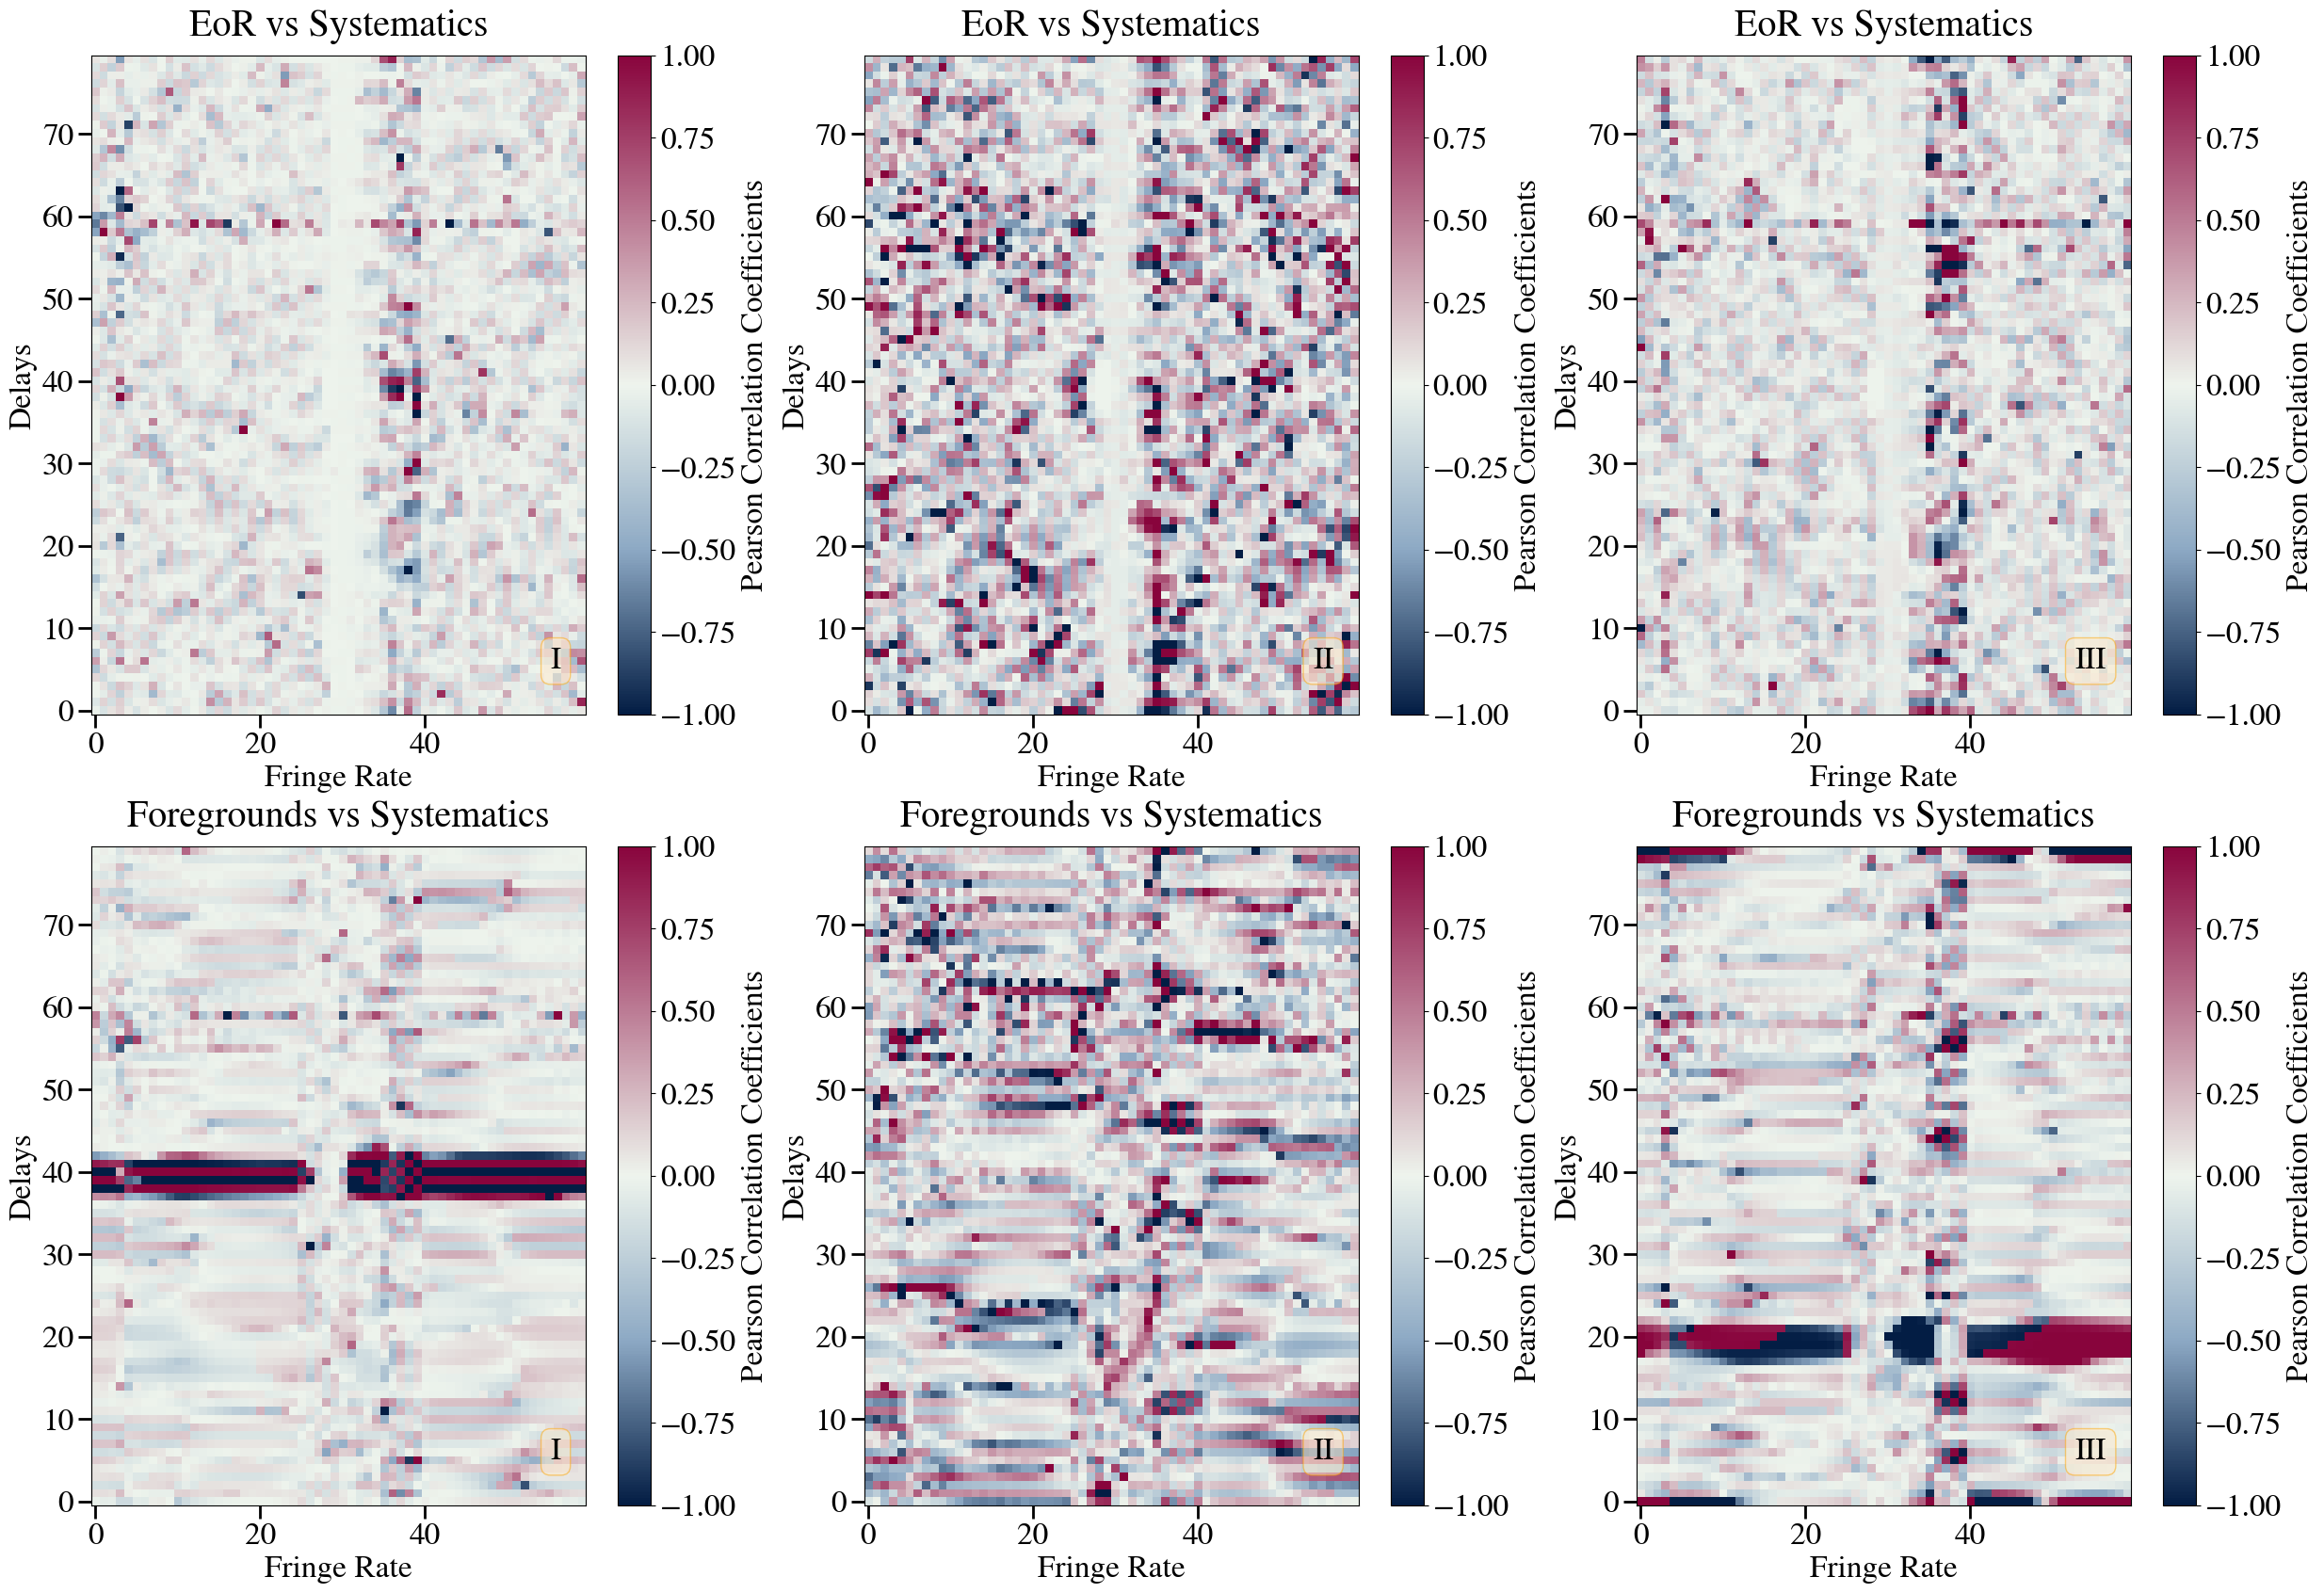

In [79]:
'''Loading Data'''
# result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/1e7_bound/10modes'
result_dir='/nvme2/scratch/sohini/hydra-pspec-systematic/paper_plots/'
run_version_arr = ['low_dl_fr_0','high_dl_fr_0','low_dl_fr_20']
fig_labels = ['I','II','III']

fig, axs = plt.subplots(2,3,figsize=(30,20))

i=0
for run_version in run_version_arr:
    fgmodes=np.load(result_dir+run_version+'/fgmodes.npy') # Only for fg_fit

    fg_amps_gcr = np.load(result_dir+run_version+'/fg-amps.npy')
    eor_gcr = np.load(result_dir+run_version+'/gcr-eor.npy')
    b_sys_gcr = np.load(result_dir+run_version+'/b-sys.npy')

    '''Vis Arrays'''
    fg_vis_arr=np.empty([fg_amps_gcr.shape[0],Ntimes,Nfreqs],dtype='complex')
    delta_g_arr = np.empty([Niter,Ntimes,Nfreqs],dtype='complex')

    '''DLFR Arrays'''
    eor_dlfr_arr=np.empty(eor_gcr.shape,dtype='complex')
    fg_dlfr_arr=np.empty(eor_gcr.shape,dtype='complex')
    sys_model_dlfr_arr = np.empty([Niter,Ntimes,Nfreqs],dtype='complex')

    print("Foregrounds...")
    for a in tqdm(range(fg_amps_gcr.shape[0])):
        fg_vis_arr[a,:,:] = (fgmodes @ fg_amps_gcr[a,:].T).T

    print("Sky DLFR...")
    for a in tqdm(range(len(eor_gcr))):
        eor_dlfr_arr[a,:,:]=data_dly_fr(eor_gcr[a,:,:],freqs*1e6, lsts, windows='blackman-harris',)
        fg_dlfr_arr[a,:,:] = data_dly_fr(fg_vis_arr[a,:,:],freqs*1e6, lsts, windows='blackman-harris',)

    print("Systematics...")
    for a in tqdm(range(Niter)):
        delta_g_arr[a,:,:] = (sys_modes_operator @ b_sys_gcr[a,:]).reshape([Nfreqs,Ntimes]).T
        sys_model_dlfr_arr[a,:,:] = data_dly_fr(1+delta_g_arr[a,:,:],freqs*1e6, lsts, windows='blackman-harris')

    corr_map_eor = plot_crosscor_pearson(eor_dlfr_arr, sys_model_dlfr_arr)
    corr_map_fg = plot_crosscor_pearson(fg_dlfr_arr, sys_model_dlfr_arr)

    im=axs[0,i].imshow(corr_map_eor[::-1,:].real,cmap=paper_map,origin='lower',vmin=-1,vmax=1)
    plt.colorbar(im,ax=axs[0,i],label='Pearson Correlation Coefficients')
    axs[0,i].set_title('EoR vs Systematics',pad=15)
    axs[0,i].text(0.95,0.07,fig_labels[i],bbox=bbox,
            transform=axs[0,i].transAxes, horizontalalignment='right')
    
    im=axs[1,i].imshow(corr_map_fg[::-1,:].real,cmap=paper_map,origin='lower',vmin=-1,vmax=1)
    plt.colorbar(im,ax=axs[1,i],label='Pearson Correlation Coefficients')
    axs[1,i].set_title('Foregrounds vs Systematics',pad=15)
    axs[1,i].text(0.95,0.07,fig_labels[i],bbox=bbox,
            transform=axs[1,i].transAxes, horizontalalignment='right')
    i=i+1

for ax in axs.flatten():
    # ax[i,j].set_title(title_list[i][j],pad=15)
    ax.set_xlabel('Fringe Rate')
    ax.set_ylabel('Delays')
    ax.tick_params(direction='out', length=6, width=2, colors='black',size=10)

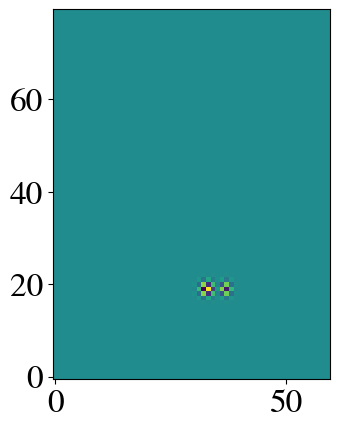

In [72]:
plt.imshow(delta_g_dlfr_mean[::-1,:].real,origin='lower')

In [57]:
corr_map.shape

(80, 60)

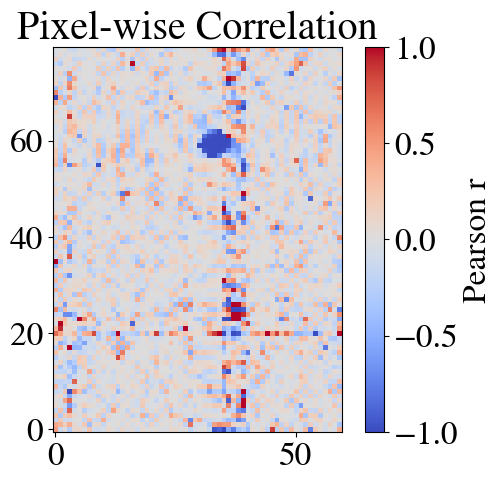

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(corr_map.real, cmap='coolwarm', vmin=-1, vmax=1,origin='lower')
plt.colorbar(label='Pearson r')
plt.title('Pixel-wise Correlation')
plt.show()


In [61]:
from scipy.stats import t

n = 10000
t_stat = corr * np.sqrt((n-2) / (1 - corr**2))
p_values = 2 * (1 - t.cdf(np.abs(t_stat), df=n-2))


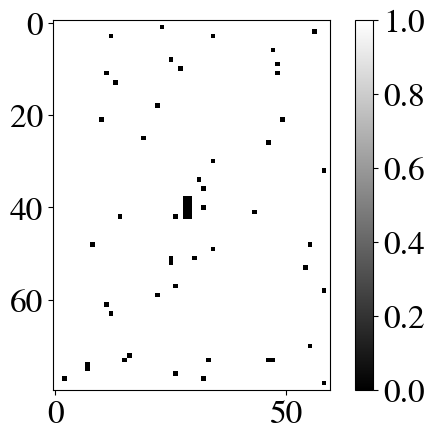

In [63]:
sig_mask = p_values < 0.01
plt.imshow(sig_mask.reshape(fg_vis_arr.shape[1:]), cmap='gray')
plt.colorbar()

In [26]:
delta_g_arr.shape

(10000, 80, 60)

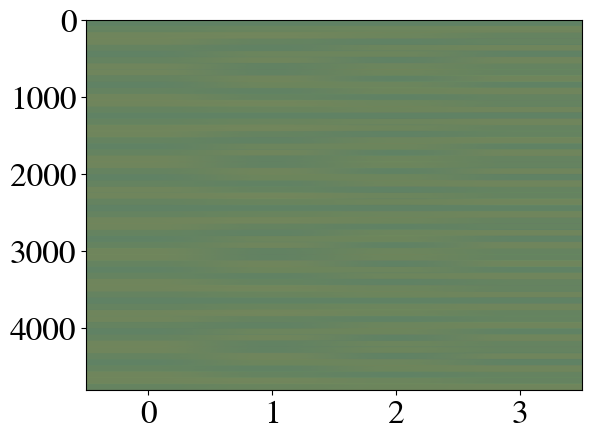

In [23]:
plt.imshow(sys_modes_operator.imag,aspect='auto')